# Analysis of the obtained results

In this notebook, we will use the code of several R scripts (analyse_test_results_boostrap.R and analyse_test_results_boostrap_BS.R), to perform an analysis of the obtained results applying MusiteDeep model to the methionine-oxidation problem.

We first load the MetOx dataset:

In [1]:
load('../MetOData.RData')

In [2]:
head(MetOData)

ACC,PDB,Met,Oxidable,Yd.chain,Fd.chain,Wd.chain,nY.chain,nF.chain,nW.chain,⋯,CT_M,CT_N,CT_P,CT_Q,CT_R,CT_S,CT_T,CT_V,CT_W,CT_Y
A5YKK6,4C0D,1883,No,10.6,4.8,8.6,0,2,0,⋯,22,37,38,2,14,27,8,24,155,28
A5YKK6,4C0D,1905,No,10.9,8.8,12.6,0,0,0,⋯,22,15,16,9,7,5,21,2,133,6
A5YKK6,4C0D,1996,No,8.3,11.6,14.2,0,0,0,⋯,55,6,8,18,31,47,14,11,42,40
A5YKK6,4C0D,2051,No,6.8,4.8,9.2,1,1,0,⋯,12,30,5,6,29,83,4,31,10,13
A5YKK6,4C0D,2063,No,9.8,5.8,10.5,0,1,0,⋯,25,18,14,3,17,71,22,19,257,1
A5YKK6,4C0D,2088,No,5.9,4.4,12.8,1,1,0,⋯,52,36,19,1,9,46,7,10,232,4


In [3]:
get_ids <- function(cad){
    unlist(strsplit(unlist(strsplit(cad, '[|]'))[2], '[.]'))[1]
}


test_analysis <- function(train.ids, metox.data, results.path) {
    test_acc <- ACC_ids[-train.ids]

    # Load results (previously computed with keras/theano - deep learning)
    test_results <- read.table(results.path, sep = '\t', col.names = c('id', 'pos', 'res', 'prob'))

    test_results$id <- as.character(test_results$id)

    test_res_ids <- sapply(test_results$id, get_ids)

    test_results$id <- test_res_ids

    test_results$Prediction <- factor(ifelse(test_results$prob > 0.5, 'Yes', 'No'), levels = c('Yes','No'))

    test_results <- test_results[, c('id', 'pos', 'prob', 'Prediction')]

    names(test_results) <- c('ACC', 'Met', 'Prob', 'Prediction')

    MetOData_test <- metox.data[metox.data$ACC %in% test_acc,c('ACC','Met','Oxidable')]
    
    return(list(test_results=test_results, MetOData_test=MetOData_test))
}


metrics_analysis <- function(test_results) {
    lvl <- rev(levels(test_results$Oxidable))
    tstROC <- roc(test_results$Oxidable, test_results$Prob, levels = lvl)
    bestVals <- coords(tstROC, 0.5, ret=c("accuracy", "sensitivity", "specificity", "tp", "tn", "fp", "fn"))

    tp <- bestVals[4]
    tn <- bestVals[5]
    fp <- bestVals[6]
    fn <- bestVals[7]
    precision <- tp / (tp + fp)
    # In binary classification, sensibility=recall
    recall <- tp / (tp + fn)
    mcc <- (tp * tn - fp * fn)/sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    Fmeasure <- 2 * precision * recall / (precision + recall)
    return(c(0.5, 
             tstROC$auc, 
             bestVals[1:3],
             precision,
             recall,
             mcc,
             Fmeasure
    ))
}


results_analysis_all <- function(train.ids, metox.data, results.path) {
    # Using all the methionines not marked as positive in MetOData as the negative samples
    
    res <- test_analysis(train.ids, metox.data, results.path)
    test_results <- res$test_results
    MetOData_test <- res$MetOData_test

    test_results$Oxidable <- rep(factor("No", levels = c("Yes", "No")), dim(test_results)[1])
    for (j in 1:(dim(MetOData_test)[1])){
        test_results[test_results$ACC == MetOData_test$ACC[j] & test_results$Met == MetOData_test$Met[j], 
                     'Oxidable'] <- MetOData_test$Oxidable[j]
    }

    # Remove the methionines at the beginning of the sequence:
    # NO! AS WE ARE CONSIDERING ALL THE NON-POSITIVE Ms AS NEGATIVE SAMPLES
    # test_results <- test_results[test_results$Met != 1,]

    return(metrics_analysis(test_results))
}


results_analysis_no_first <- function(train.ids, metox.data, results.path) {
    # Using all the methionines not marked as positive in MetOData as the negative samples, except the first ones
    
    res <- test_analysis(train.ids, metox.data, results.path)
    test_results <- res$test_results
    MetOData_test <- res$MetOData_test
    
    # As we removed the first Met
    test_results$Met <- test_results$Met + 1
    
    test_results$Oxidable <- rep(factor("No", levels = c("Yes", "No")), dim(test_results)[1])
    for (j in 1:(dim(MetOData_test)[1])){
        test_results[test_results$ACC == MetOData_test$ACC[j] & test_results$Met == MetOData_test$Met[j], 
                     'Oxidable'] <- MetOData_test$Oxidable[j]
    }

    return(metrics_analysis(test_results))
}


results_analysis_original <- function(train.ids, metox.data, results.path) {
    # Using only the methionines contained in MetOData
    
    res <- test_analysis(train.ids, metox.data, results.path)
    test_results <- res$test_results
    MetOData_test <- res$MetOData_test

    test_results <- merge(test_results, MetOData_test)

    return(metrics_analysis(test_results))
}

## Using repeated holdout strategy

In [4]:
library(pROC)

NM_BS <- 10 # Number of holdout repetitions

ACC_ids <- unique(MetOData$ACC)

sts <- as.data.frame(matrix(rep(0,9*NM_BS),NM_BS,9))

names(sts) <- c("cut", 
                "ROC", 
                "Acc", 
                "Sens", 
                "Spec", 
                "Prec", 
                "Recal", 
                'MCC', 
                'FMeas')

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [5]:
# To compare all obtained results using repeated-holdout strategy
r.names <- c('Original', 'Custom ST 5', 'Custom ST 1', 'Custom ST 1 non-M', 'Custom STY 5', 'Custom STY 1', 
             'Custom STY 1 lr=0.00075', 'Custom STY 1 tl=0 lr=0.00075', 'Custom STY 1 lr=0.0005', 
             'Custom STY 1 tl=0 lr=0.0005', 'Custom STY 1 lr=0.0003', 'Custom STY 1 lr=0.0001', 
             'Custom STY 1 tl=0 lr=0.0001', 'Custom STY 1 lr=0.005', 'Custom STY 1 lr=0.01', 'Custom STY 1 tl=0', 
             'Custom STY 1 tl=3', 'Custom STY 1 tl=5', 'Custom STY 1 non-M', 'DeepBind ST 1')

In [6]:
rep.hold.mean <- as.data.frame(matrix(rep(0,length(r.names)*9),length(r.names),9))
colnames(rep.hold.mean) <- names(sts)
rownames(rep.hold.mean) <- r.names
rep.hold.std <- rep.hold.mean

### Using all methionines

#### Original pre-trained model

We analyse the results obtained using the original general model pre-trained by the authors on general phosphorylation data (S, T residues).

In [7]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('../../MusiteDeep/metox_results_' , i, 
                                                            '.txt_custom.txt'))
}

In [8]:
print('Mean:')
rep.hold.mean['Original', ] <- sapply(sts,mean)
print(rep.hold.mean['Original', ])

print('Std:')
rep.hold.std['Original', ] <- sapply(sts,sd)
print(rep.hold.std['Original', ])

[1] "Mean:"
         cut       ROC       Acc      Sens      Spec      Prec     Recal
Original 0.5 0.8238655 0.8163017 0.6090743 0.8315699 0.2076082 0.6090743
               MCC     FMeas
Original 0.2768966 0.3086881
[1] "Std:"
         cut        ROC        Acc       Sens       Spec       Prec      Recal
Original   0 0.03109605 0.01066145 0.09122282 0.01422944 0.02478852 0.09122282
                MCC      FMeas
Original 0.04660424 0.03500513


#### Custom pre-training

We now analyse the results obtained using our custom general model pre-trained on general phosphorylation data.

##### Residues S, T

Using nclass=5:

In [9]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('results/rephold-ST-nclass5/metox_result_custom_general_ST_', 
                                                            i, '.txt_custom.txt'))
}

In [10]:
print('Mean:')
rep.hold.mean['Custom ST 5', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom ST 5', ])

print('Std:')
rep.hold.std['Custom ST 5', ] <- sapply(sts,sd)
print(rep.hold.std['Custom ST 5', ])

[1] "Mean:"
            cut      ROC       Acc      Sens      Spec      Prec     Recal
Custom ST 5 0.5 0.815396 0.7961064 0.6075792 0.8100338 0.1881427 0.6075792
                  MCC     FMeas
Custom ST 5 0.2532618 0.2863049
[1] "Std:"
            cut       ROC        Acc       Sens       Spec       Prec
Custom ST 5   0 0.0284932 0.01576468 0.09300165 0.02054169 0.02030786
                 Recal        MCC      FMeas
Custom ST 5 0.09300165 0.04231361 0.02983927


Using nclass=1:

In [11]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('results/rephold-ST-nclass1/metox_result_custom_general_ST_', 
                                                            i, '_custom.txt'))
}

In [12]:
print('Mean:')
rep.hold.mean['Custom ST 1', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom ST 1', ])

print('Std:')
rep.hold.std['Custom ST 1', ] <- sapply(sts,sd)
print(rep.hold.std['Custom ST 1', ])

[1] "Mean:"
            cut       ROC       Acc      Sens     Spec      Prec     Recal
Custom ST 1 0.5 0.8148884 0.8012263 0.6172389 0.814869 0.1939756 0.6172389
                  MCC     FMeas
Custom ST 1 0.2631361 0.2933656
[1] "Std:"
            cut        ROC        Acc      Sens      Spec       Prec     Recal
Custom ST 1   0 0.02918357 0.01768064 0.1172025 0.0272063 0.01470539 0.1172025
                   MCC      FMeas
Custom ST 1 0.04149572 0.02465926


Results seem to be so slightly better and more stable when using a value of 5 for nclass parameter, though nclass=1 is less computationally demanding.

##### Residues S, T, Y

Using nclass=5:

In [13]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('results/rephold-STY-nclass5/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [14]:
print('Mean:')
rep.hold.mean['Custom STY 5', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 5', ])

print('Std:')
rep.hold.std['Custom STY 5', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 5', ])

[1] "Mean:"
             cut       ROC       Acc      Sens      Spec      Prec     Recal
Custom STY 5 0.5 0.8294423 0.8028139 0.6742581 0.8124572 0.2083341 0.6742581
                   MCC     FMeas
Custom STY 5 0.2953061 0.3167181
[1] "Std:"
             cut        ROC        Acc       Sens       Spec       Prec
Custom STY 5   0 0.02671342 0.02351413 0.09254205 0.02806553 0.02753488
                  Recal        MCC      FMeas
Custom STY 5 0.09254205 0.04495629 0.03585001


Using nclass=1:

In [15]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('results/rephold-STY-nclass1/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [16]:
print('Mean:')
rep.hold.mean['Custom STY 1', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1', ])

print('Std:')
rep.hold.std['Custom STY 1', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1', ])

[1] "Mean:"
             cut      ROC       Acc      Sens      Spec      Prec     Recal
Custom STY 1 0.5 0.826321 0.7988595 0.6681704 0.8087247 0.2047675 0.6681704
                   MCC     FMeas
Custom STY 1 0.2886493 0.3113627
[1] "Std:"
             cut        ROC    Acc       Sens       Spec       Prec      Recal
Custom STY 1   0 0.02939644 0.0295 0.08494603 0.03502025 0.02891143 0.08494603
                    MCC      FMeas
Custom STY 1 0.03946518 0.03425851


Comparing the results obtained when pre-training on residues S, T and S, T, Y, better results are obtained when using the three residues.

###### Learning-rate

We will now try different values of the learning-rate used by the Adam optimizer, using the custom pre-trained model on S, T, Y residues using nclass=1.

Using lr=0.00075:

In [17]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('lr/results/rephold-STY-nclass1-lr00075/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [18]:
print('Mean:')
rep.hold.mean['Custom STY 1 lr=0.00075', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 lr=0.00075', ])

print('Std:')
rep.hold.std['Custom STY 1 lr=0.00075', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 lr=0.00075', ])

[1] "Mean:"
                        cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 lr=0.00075 0.5 0.8216875 0.7717383 0.7071945 0.7766227 0.1874095
                            Recal       MCC     FMeas
Custom STY 1 lr=0.00075 0.7071945 0.2784662 0.2953826
[1] "Std:"
                        cut        ROC        Acc      Sens       Spec
Custom STY 1 lr=0.00075   0 0.02782368 0.02107715 0.0777472 0.02569073
                              Prec     Recal        MCC      FMeas
Custom STY 1 lr=0.00075 0.01893803 0.0777472 0.03312665 0.02477944


Using lr=0.0005:

In [19]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('lr/results/rephold-STY-nclass1-lr0005/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [20]:
print('Mean:')
rep.hold.mean['Custom STY 1 lr=0.0005', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 lr=0.0005', ])

print('Std:')
rep.hold.std['Custom STY 1 lr=0.0005', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 lr=0.0005', ])

[1] "Mean:"
                       cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 lr=0.0005 0.5 0.8161592 0.7423471 0.7334584 0.7431334 0.1717636
                           Recal       MCC     FMeas
Custom STY 1 lr=0.0005 0.7334584 0.2639003 0.2776253
[1] "Std:"
                       cut        ROC        Acc       Sens       Spec
Custom STY 1 lr=0.0005   0 0.02857603 0.02420475 0.09474244 0.03038141
                             Prec      Recal        MCC      FMeas
Custom STY 1 lr=0.0005 0.01366154 0.09474244 0.03500368 0.02054266


Using lr=0.0003:

In [21]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('lr/results/rephold-STY-nclass1-lr0003/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [22]:
print('Mean:')
rep.hold.mean['Custom STY 1 lr=0.0003', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 lr=0.0003', ])

print('Std:')
rep.hold.std['Custom STY 1 lr=0.0003', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 lr=0.0003', ])

[1] "Mean:"
                       cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 lr=0.0003 0.5 0.8163477 0.7404969 0.7305155 0.7413243 0.1711594
                           Recal       MCC     FMeas
Custom STY 1 lr=0.0003 0.7305155 0.2617963 0.2764799
[1] "Std:"
                       cut        ROC        Acc       Sens       Spec
Custom STY 1 lr=0.0003   0 0.02314375 0.03224602 0.08296853 0.03808021
                            Prec      Recal        MCC      FMeas
Custom STY 1 lr=0.0003 0.0188306 0.08296853 0.03527307 0.02655794


Using lr=0.0001:

In [23]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('lr/results/rephold-STY-nclass1-lr0001/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [24]:
print('Mean:')
rep.hold.mean['Custom STY 1 lr=0.0001', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 lr=0.0001', ])

print('Std:')
rep.hold.std['Custom STY 1 lr=0.0001', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 lr=0.0001', ])

[1] "Mean:"
                       cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 lr=0.0001 0.5 0.8044292 0.6875145 0.7993104 0.6792511 0.1536202
                           Recal      MCC     FMeas
Custom STY 1 lr=0.0001 0.7993104 0.251902 0.2575997
[1] "Std:"
                       cut        ROC        Acc       Sens      Spec
Custom STY 1 lr=0.0001   0 0.02984998 0.02876941 0.07526568 0.0312009
                             Prec      Recal        MCC      FMeas
Custom STY 1 lr=0.0001 0.01525182 0.07526568 0.04151994 0.02474123


Using lr=0.005:

In [25]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('lr/results/rephold-STY-nclass1-lr005/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [26]:
print('Mean:')
rep.hold.mean['Custom STY 1 lr=0.005', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 lr=0.005', ])

print('Std:')
rep.hold.std['Custom STY 1 lr=0.005', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 lr=0.005', ])

[1] "Mean:"
                      cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 lr=0.005 0.5 0.8283994 0.8805647 0.4458099 0.9123172 0.2688491
                          Recal       MCC     FMeas
Custom STY 1 lr=0.005 0.4458099 0.2838178 0.3325091
[1] "Std:"
                      cut        ROC        Acc      Sens       Spec       Prec
Custom STY 1 lr=0.005   0 0.03294771 0.01355111 0.1095603 0.01684532 0.04365477
                          Recal        MCC      FMeas
Custom STY 1 lr=0.005 0.1095603 0.06756945 0.05876657


Using lr=0.01:

In [27]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('lr/results/rephold-STY-nclass1-lr01/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [28]:
print('Mean:')
rep.hold.mean['Custom STY 1 lr=0.01', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 lr=0.01', ])

print('Std:')
rep.hold.std['Custom STY 1 lr=0.01', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 lr=0.01', ])

[1] "Mean:"
                     cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 lr=0.01 0.5 0.8261484 0.8507798 0.5159344 0.8750115 0.2343945
                         Recal       MCC    FMeas
Custom STY 1 lr=0.01 0.5159344 0.2746472 0.315121
[1] "Std:"
                     cut        ROC        Acc      Sens       Spec       Prec
Custom STY 1 lr=0.01   0 0.03853304 0.03770155 0.1799897 0.04856218 0.04212801
                         Recal        MCC      FMeas
Custom STY 1 lr=0.01 0.1799897 0.07926811 0.06124987


###### Transfer-leayer

We will now try different values of the transfer-leayer argument, using the custom pre-trained model on S, T, Y residues using nclass=1.

Using transfer-leayer=0:

In [29]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('transfer-leayer/results/rephold-STY-nclass1-tl0/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [30]:
print('Mean:')
rep.hold.mean['Custom STY 1 tl=0', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 tl=0', ])

print('Std:')
rep.hold.std['Custom STY 1 tl=0', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 tl=0', ])

[1] "Mean:"
                  cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 tl=0 0.5 0.8340293 0.8383975 0.6011161 0.8558756 0.2314928
                      Recal       MCC     FMeas
Custom STY 1 tl=0 0.6011161 0.3007892 0.3330084
[1] "Std:"
                  cut        ROC         Acc      Sens       Spec       Prec
Custom STY 1 tl=0   0 0.02889968 0.008445571 0.1023009 0.01288152 0.02631334
                      Recal        MCC      FMeas
Custom STY 1 tl=0 0.1023009 0.05124698 0.03801741


Using transfer-leayer=3:

In [31]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('transfer-leayer/results/rephold-STY-nclass1-tl3/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [32]:
print('Mean:')
rep.hold.mean['Custom STY 1 tl=3', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 tl=3', ])

print('Std:')
rep.hold.std['Custom STY 1 tl=3', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 tl=3', ])

[1] "Mean:"
                  cut     ROC      Acc      Sens      Spec      Prec     Recal
Custom STY 1 tl=3 0.5 0.82536 0.794317 0.6613467 0.8042168 0.1973269 0.6613467
                        MCC     FMeas
Custom STY 1 tl=3 0.2788386 0.3027874
[1] "Std:"
                  cut        ROC        Acc      Sens       Spec       Prec
Custom STY 1 tl=3   0 0.03084594 0.02116507 0.1044433 0.02494828 0.02628709
                      Recal       MCC      FMeas
Custom STY 1 tl=3 0.1044433 0.0519605 0.03768799


Using transfer-leayer=5:

In [33]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('transfer-leayer/results/rephold-STY-nclass1-tl5/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [34]:
print('Mean:')
rep.hold.mean['Custom STY 1 tl=5', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 tl=5', ])

print('Std:')
rep.hold.std['Custom STY 1 tl=5', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 tl=5', ])

[1] "Mean:"
                  cut       ROC      Acc      Sens      Spec      Prec
Custom STY 1 tl=5 0.5 0.7981474 0.770023 0.6420739 0.7794126 0.1754853
                      Recal       MCC     FMeas
Custom STY 1 tl=5 0.6420739 0.2453631 0.2745123
[1] "Std:"
                  cut        ROC       Acc      Sens       Spec       Prec
Custom STY 1 tl=5   0 0.02740713 0.0270307 0.0839048 0.03264291 0.01891957
                      Recal        MCC      FMeas
Custom STY 1 tl=5 0.0839048 0.03437418 0.02556955


##### Transfer-leayer and learning-rate

Using transfer-leayer=0 and lr=0.00075:

In [35]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('transfer-leayer/results/rephold-STY-nclass1-tl0-lr00075/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [36]:
print('Mean:')
rep.hold.mean['Custom STY 1 tl=0 lr=0.00075', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 tl=0 lr=0.00075', ])

print('Std:')
rep.hold.std['Custom STY 1 tl=0 lr=0.00075', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 tl=0 lr=0.00075', ])

[1] "Mean:"
                             cut       ROC      Acc      Sens      Spec
Custom STY 1 tl=0 lr=0.00075 0.5 0.8322186 0.824983 0.6085878 0.8409189
                                  Prec     Recal       MCC     FMeas
Custom STY 1 tl=0 lr=0.00075 0.2171963 0.6085878 0.2873916 0.3188084
[1] "Std:"
                             cut       ROC        Acc      Sens      Spec
Custom STY 1 tl=0 lr=0.00075   0 0.0298327 0.01477558 0.1008747 0.0192692
                                   Prec     Recal        MCC      FMeas
Custom STY 1 tl=0 lr=0.00075 0.02538421 0.1008747 0.04826204 0.03592851


Using transfer-leayer=0 and lr=0.0005:

In [37]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('transfer-leayer/results/rephold-STY-nclass1-tl0-lr0005/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [38]:
print('Mean:')
rep.hold.mean['Custom STY 1 tl=0 lr=0.0005', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 tl=0 lr=0.0005', ])

print('Std:')
rep.hold.std['Custom STY 1 tl=0 lr=0.0005', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 tl=0 lr=0.0005', ])

[1] "Mean:"
                            cut       ROC       Acc      Sens      Spec
Custom STY 1 tl=0 lr=0.0005 0.5 0.8310176 0.8007972 0.6855445 0.8093064
                                 Prec     Recal       MCC     FMeas
Custom STY 1 tl=0 lr=0.0005 0.2064366 0.6855445 0.2973089 0.3167262
[1] "Std:"
                            cut        ROC         Acc       Sens       Spec
Custom STY 1 tl=0 lr=0.0005   0 0.02875841 0.009928408 0.09362511 0.01270257
                                  Prec      Recal        MCC     FMeas
Custom STY 1 tl=0 lr=0.0005 0.02156982 0.09362511 0.04660939 0.0327711


Using transfer-leayer=0 and lr=0.0001:

In [39]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('transfer-leayer/results/rephold-STY-nclass1-tl0-lr0001/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [40]:
print('Mean:')
rep.hold.mean['Custom STY 1 tl=0 lr=0.0001', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 tl=0 lr=0.0001', ])

print('Std:')
rep.hold.std['Custom STY 1 tl=0 lr=0.0001', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 tl=0 lr=0.0001', ])

[1] "Mean:"
                            cut       ROC       Acc     Sens      Spec
Custom STY 1 tl=0 lr=0.0001 0.5 0.8225759 0.7403841 0.746837 0.7400286
                                 Prec    Recal       MCC     FMeas
Custom STY 1 tl=0 lr=0.0001 0.1728334 0.746837 0.2687882 0.2800834
[1] "Std:"
                            cut        ROC        Acc       Sens       Spec
Custom STY 1 tl=0 lr=0.0001   0 0.02775231 0.02022582 0.09889931 0.02388347
                                  Prec      Recal        MCC      FMeas
Custom STY 1 tl=0 lr=0.0001 0.02166504 0.09889931 0.04805319 0.03296256


#### DeepBind pre-training

We now analyse the results obtained using the DeepBind model, fristly pre-trained on general phosphorylation data and then fine-tuned on methionine-oxidation data.

##### Residues S, T

Using nclass=1:

In [41]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_all(train_ids, MetOData, paste0('deepbind/results/rephold-ST-nclass1/metox_result_deep_bind_ST_', 
                                                            i, '_custom.txt'))
}

In [42]:
print('Mean:')
rep.hold.mean['DeepBind ST 1', ] <- sapply(sts,mean)
print(rep.hold.mean['DeepBind ST 1', ])

print('Std:')
rep.hold.std['DeepBind ST 1', ] <- sapply(sts,sd)
print(rep.hold.std['DeepBind ST 1', ])

[1] "Mean:"
              cut       ROC       Acc Sens Spec Prec Recal MCC FMeas
DeepBind ST 1 0.5 0.7064368 0.9322569    0    1  NaN     0 NaN   NaN
[1] "Std:"
              cut        ROC         Acc Sens Spec Prec Recal MCC FMeas
DeepBind ST 1   0 0.04500395 0.004716135    0    0   NA     0  NA    NA


### Using all methionines except the N-terminal Met

#### Custom pre-training

We analyse the results obtained using our custom general model pre-trained on general phosphorylation data.

##### Residues S, T

Using nclass=1:

In [43]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_no_first(train_ids, MetOData, paste0('musite-fasta-M/results/rephold-ST-nclass1/metox_result_custom_general_ST_', 
                                                            i, '_custom.txt'))
}

In [44]:
print('Mean:')
rep.hold.mean['Custom ST 1 non-M', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom ST 1 non-M', ])

print('Std:')
rep.hold.std['Custom ST 1 non-M', ] <- sapply(sts,sd)
print(rep.hold.std['Custom ST 1 non-M', ])

[1] "Mean:"
                  cut       ROC       Acc      Sens      Spec      Prec
Custom ST 1 non-M 0.5 0.8012535 0.7815378 0.6149266 0.7948345 0.1885375
                      Recal      MCC    FMeas
Custom ST 1 non-M 0.6149266 0.249182 0.287114
[1] "Std:"
                  cut        ROC        Acc      Sens       Spec       Prec
Custom ST 1 non-M   0 0.03145652 0.01991037 0.1130456 0.02803016 0.01792801
                      Recal        MCC      FMeas
Custom ST 1 non-M 0.1130456 0.04397392 0.02789756


##### Residues S, T, Y

Using nclass=1:

In [45]:
for (i in 1:NM_BS){
    # Split proteins for training and testing
    set.seed(i)
    train_ids <- sample(length(ACC_ids), floor(length(ACC_ids) * 0.7))
    
    sts[i,] <- results_analysis_no_first(train_ids, MetOData, paste0('musite-fasta-M/results/rephold-STY-nclass1/metox_result_custom_general_STY_', 
                                                            i, '_custom.txt'))
}

In [46]:
print('Mean:')
rep.hold.mean['Custom STY 1 non-M', ] <- sapply(sts,mean)
print(rep.hold.mean['Custom STY 1 non-M', ])

print('Std:')
rep.hold.std['Custom STY 1 non-M', ] <- sapply(sts,sd)
print(rep.hold.std['Custom STY 1 non-M', ])

[1] "Mean:"
                   cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 non-M 0.5 0.8107846 0.7780797 0.6900976 0.7852456 0.2016288
                       Recal       MCC     FMeas
Custom STY 1 non-M 0.6900976 0.2851584 0.3106313
[1] "Std:"
                   cut        ROC       Acc       Sens      Spec       Prec
Custom STY 1 non-M   0 0.02905392 0.0264928 0.08565022 0.0313047 0.02863806
                        Recal       MCC      FMeas
Custom STY 1 non-M 0.08565022 0.0432396 0.03660558


### Final results

In [47]:
# To compare the results obtained using default values of the learning rate (lr=0.001) and the transfer-leayer (=1)

# Mean values
rep.hold.mean[c('Original', 'Custom ST 5', 'Custom ST 1', 'Custom ST 1 non-M', 'Custom STY 5', 'Custom STY 1', 
               'Custom STY 1 non-M'), ]

# Std values
rep.hold.std[c('Original', 'Custom ST 5', 'Custom ST 1', 'Custom ST 1 non-M', 'Custom STY 5', 'Custom STY 1', 
               'Custom STY 1 non-M'), ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Original,0.5,0.8238655,0.8163017,0.6090743,0.8315699,0.2076082,0.6090743,0.2768966,0.3086881
Custom ST 5,0.5,0.8153960,0.7961064,0.6075792,0.8100338,0.1881427,0.6075792,0.2532618,0.2863049
Custom ST 1,0.5,0.8148884,0.8012263,0.6172389,0.8148690,0.1939756,0.6172389,0.2631361,0.2933656
Custom ST 1 non-M,0.5,0.8012535,0.7815378,0.6149266,0.7948345,0.1885375,0.6149266,0.2491820,0.2871140
Custom STY 5,0.5,0.8294423,0.8028139,0.6742581,0.8124572,0.2083341,0.6742581,0.2953061,0.3167181
Custom STY 1,0.5,0.8263210,0.7988595,0.6681704,0.8087247,0.2047675,0.6681704,0.2886493,0.3113627
Custom STY 1 non-M,0.5,0.8107846,0.7780797,0.6900976,0.7852456,0.2016288,0.6900976,0.2851584,0.3106313


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Original,0,0.03109605,0.01066145,0.09122282,0.01422944,0.02478852,0.09122282,0.04660424,0.03500513
Custom ST 5,0,0.02849320,0.01576468,0.09300165,0.02054169,0.02030786,0.09300165,0.04231361,0.02983927
Custom ST 1,0,0.02918357,0.01768064,0.11720252,0.02720630,0.01470539,0.11720252,0.04149572,0.02465926
Custom ST 1 non-M,0,0.03145652,0.01991037,0.11304556,0.02803016,0.01792801,0.11304556,0.04397392,0.02789756
Custom STY 5,0,0.02671342,0.02351413,0.09254205,0.02806553,0.02753488,0.09254205,0.04495629,0.03585001
Custom STY 1,0,0.02939644,0.02950000,0.08494603,0.03502025,0.02891143,0.08494603,0.03946518,0.03425851
Custom STY 1 non-M,0,0.02905392,0.02649280,0.08565022,0.03130470,0.02863806,0.08565022,0.04323960,0.03660558


Comparing the results obtained when using the original and the custom pre-trained models, according to ROC and Sens, results are better when using our S, T, Y custom general model, although ACC and Spec values are better when using the original model pre-trained on S, T residues.

In [48]:
# Comparing the different results obtained using different values of learning-rate

# Mean values
rep.hold.mean[c('Custom STY 1', 'Custom STY 1 lr=0.00075', 'Custom STY 1 lr=0.0005', 'Custom STY 1 lr=0.0003', 
                'Custom STY 1 lr=0.0001', 'Custom STY 1 lr=0.005', 'Custom STY 1 lr=0.01'), ]

# Std values
rep.hold.std[c('Custom STY 1', 'Custom STY 1 lr=0.00075', 'Custom STY 1 lr=0.0005', 'Custom STY 1 lr=0.0003', 
                'Custom STY 1 lr=0.0001', 'Custom STY 1 lr=0.005', 'Custom STY 1 lr=0.01'), ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0.5,0.8263210,0.7988595,0.6681704,0.8087247,0.2047675,0.6681704,0.2886493,0.3113627
Custom STY 1 lr=0.00075,0.5,0.8216875,0.7717383,0.7071945,0.7766227,0.1874095,0.7071945,0.2784662,0.2953826
Custom STY 1 lr=0.0005,0.5,0.8161592,0.7423471,0.7334584,0.7431334,0.1717636,0.7334584,0.2639003,0.2776253
Custom STY 1 lr=0.0003,0.5,0.8163477,0.7404969,0.7305155,0.7413243,0.1711594,0.7305155,0.2617963,0.2764799
Custom STY 1 lr=0.0001,0.5,0.8044292,0.6875145,0.7993104,0.6792511,0.1536202,0.7993104,0.2519020,0.2575997
Custom STY 1 lr=0.005,0.5,0.8283994,0.8805647,0.4458099,0.9123172,0.2688491,0.4458099,0.2838178,0.3325091
Custom STY 1 lr=0.01,0.5,0.8261484,0.8507798,0.5159344,0.8750115,0.2343945,0.5159344,0.2746472,0.3151210


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0,0.02939644,0.02950000,0.08494603,0.03502025,0.02891143,0.08494603,0.03946518,0.03425851
Custom STY 1 lr=0.00075,0,0.02782368,0.02107715,0.07774720,0.02569073,0.01893803,0.07774720,0.03312665,0.02477944
Custom STY 1 lr=0.0005,0,0.02857603,0.02420475,0.09474244,0.03038141,0.01366154,0.09474244,0.03500368,0.02054266
Custom STY 1 lr=0.0003,0,0.02314375,0.03224602,0.08296853,0.03808021,0.01883060,0.08296853,0.03527307,0.02655794
Custom STY 1 lr=0.0001,0,0.02984998,0.02876941,0.07526568,0.03120090,0.01525182,0.07526568,0.04151994,0.02474123
Custom STY 1 lr=0.005,0,0.03294771,0.01355111,0.10956028,0.01684532,0.04365477,0.10956028,0.06756945,0.05876657
Custom STY 1 lr=0.01,0,0.03853304,0.03770155,0.17998967,0.04856218,0.04212801,0.17998967,0.07926811,0.06124987


In [49]:
# Comparing the results obtained using different values of transfer-leayer

# Mean values
rep.hold.mean[c('Custom STY 1', 'Custom STY 1 tl=0', 'Custom STY 1 tl=3', 'Custom STY 1 tl=5'), ]

# Std values
rep.hold.std[c('Custom STY 1', 'Custom STY 1 tl=0', 'Custom STY 1 tl=3', 'Custom STY 1 tl=5'), ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0.5,0.8263210,0.7988595,0.6681704,0.8087247,0.2047675,0.6681704,0.2886493,0.3113627
Custom STY 1 tl=0,0.5,0.8340293,0.8383975,0.6011161,0.8558756,0.2314928,0.6011161,0.3007892,0.3330084
Custom STY 1 tl=3,0.5,0.8253600,0.7943170,0.6613467,0.8042168,0.1973269,0.6613467,0.2788386,0.3027874
Custom STY 1 tl=5,0.5,0.7981474,0.7700230,0.6420739,0.7794126,0.1754853,0.6420739,0.2453631,0.2745123


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0,0.02939644,0.029500002,0.08494603,0.03502025,0.02891143,0.08494603,0.03946518,0.03425851
Custom STY 1 tl=0,0,0.02889968,0.008445571,0.10230094,0.01288152,0.02631334,0.10230094,0.05124698,0.03801741
Custom STY 1 tl=3,0,0.03084594,0.021165072,0.10444335,0.02494828,0.02628709,0.10444335,0.05196050,0.03768799
Custom STY 1 tl=5,0,0.02740713,0.027030702,0.08390480,0.03264291,0.01891957,0.08390480,0.03437418,0.02556955


In [50]:
# Comparing the results obtained using different values of learning-rate and transfer-leayer

# Mean values
rep.hold.mean[c('Custom STY 1', 'Custom STY 1 tl=0 lr=0.00075', 'Custom STY 1 lr=0.00075', 'Custom STY 1 tl=0', 
                'Custom STY 1 lr=0.0005', 'Custom STY 1 tl=0 lr=0.0005', 'Custom STY 1 lr=0.0001', 
                'Custom STY 1 tl=0 lr=0.0001'), ]

# Std values
rep.hold.std[c('Custom STY 1', 'Custom STY 1 tl=0 lr=0.00075', 'Custom STY 1 lr=0.00075', 'Custom STY 1 tl=0', 
               'Custom STY 1 lr=0.0005', 'Custom STY 1 tl=0 lr=0.0005', 'Custom STY 1 lr=0.0001', 
                'Custom STY 1 tl=0 lr=0.0001'), ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0.5,0.8263210,0.7988595,0.6681704,0.8087247,0.2047675,0.6681704,0.2886493,0.3113627
Custom STY 1 tl=0 lr=0.00075,0.5,0.8322186,0.8249830,0.6085878,0.8409189,0.2171963,0.6085878,0.2873916,0.3188084
Custom STY 1 lr=0.00075,0.5,0.8216875,0.7717383,0.7071945,0.7766227,0.1874095,0.7071945,0.2784662,0.2953826
Custom STY 1 tl=0,0.5,0.8340293,0.8383975,0.6011161,0.8558756,0.2314928,0.6011161,0.3007892,0.3330084
Custom STY 1 lr=0.0005,0.5,0.8161592,0.7423471,0.7334584,0.7431334,0.1717636,0.7334584,0.2639003,0.2776253
Custom STY 1 tl=0 lr=0.0005,0.5,0.8310176,0.8007972,0.6855445,0.8093064,0.2064366,0.6855445,0.2973089,0.3167262
Custom STY 1 lr=0.0001,0.5,0.8044292,0.6875145,0.7993104,0.6792511,0.1536202,0.7993104,0.2519020,0.2575997
Custom STY 1 tl=0 lr=0.0001,0.5,0.8225759,0.7403841,0.7468370,0.7400286,0.1728334,0.7468370,0.2687882,0.2800834


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0,0.02939644,0.029500002,0.08494603,0.03502025,0.02891143,0.08494603,0.03946518,0.03425851
Custom STY 1 tl=0 lr=0.00075,0,0.02983270,0.014775580,0.10087471,0.01926920,0.02538421,0.10087471,0.04826204,0.03592851
Custom STY 1 lr=0.00075,0,0.02782368,0.021077152,0.07774720,0.02569073,0.01893803,0.07774720,0.03312665,0.02477944
Custom STY 1 tl=0,0,0.02889968,0.008445571,0.10230094,0.01288152,0.02631334,0.10230094,0.05124698,0.03801741
Custom STY 1 lr=0.0005,0,0.02857603,0.024204748,0.09474244,0.03038141,0.01366154,0.09474244,0.03500368,0.02054266
Custom STY 1 tl=0 lr=0.0005,0,0.02875841,0.009928408,0.09362511,0.01270257,0.02156982,0.09362511,0.04660939,0.03277110
Custom STY 1 lr=0.0001,0,0.02984998,0.028769406,0.07526568,0.03120090,0.01525182,0.07526568,0.04151994,0.02474123
Custom STY 1 tl=0 lr=0.0001,0,0.02775231,0.020225819,0.09889931,0.02388347,0.02166504,0.09889931,0.04805319,0.03296256


In [51]:
# Comparing the comparable best obtained values

# Mean values
rep.hold.mean[c('Custom STY 1', 'Custom STY 1 lr=0.00075', 'Custom STY 1 tl=0 lr=0.0005', 
                'Custom STY 1 tl=0 lr=0.0001'), ]

# Std values
rep.hold.std[c('Custom STY 1', 'Custom STY 1 lr=0.00075', 'Custom STY 1 tl=0 lr=0.0005', 
                'Custom STY 1 tl=0 lr=0.0001'), ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0.5,0.8263210,0.7988595,0.6681704,0.8087247,0.2047675,0.6681704,0.2886493,0.3113627
Custom STY 1 lr=0.00075,0.5,0.8216875,0.7717383,0.7071945,0.7766227,0.1874095,0.7071945,0.2784662,0.2953826
Custom STY 1 tl=0 lr=0.0005,0.5,0.8310176,0.8007972,0.6855445,0.8093064,0.2064366,0.6855445,0.2973089,0.3167262
Custom STY 1 tl=0 lr=0.0001,0.5,0.8225759,0.7403841,0.7468370,0.7400286,0.1728334,0.7468370,0.2687882,0.2800834


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0,0.02939644,0.029500002,0.08494603,0.03502025,0.02891143,0.08494603,0.03946518,0.03425851
Custom STY 1 lr=0.00075,0,0.02782368,0.021077152,0.07774720,0.02569073,0.01893803,0.07774720,0.03312665,0.02477944
Custom STY 1 tl=0 lr=0.0005,0,0.02875841,0.009928408,0.09362511,0.01270257,0.02156982,0.09362511,0.04660939,0.03277110
Custom STY 1 tl=0 lr=0.0001,0,0.02775231,0.020225819,0.09889931,0.02388347,0.02166504,0.09889931,0.04805319,0.03296256


# Using bootstrap strategy

In [4]:
library(pROC)
library(caret)

NM_BS <- 100 # Number of boostrap repetitions

ACC_ids <- unique(MetOData$ACC)

sts <- as.data.frame(matrix(rep(0,9*NM_BS),NM_BS,9))

names(sts) <- c("cut", 
                "ROC", 
                "Acc", 
                "Sens", 
                "Spec", 
                "Prec", 
                "Recal", 
                'MCC', 
                'FMeas')

set.seed(1)
train_ids_bs <- createResample(y = ACC_ids, times = NM_BS)

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: lattice
Loading required package: ggplot2


In [5]:
# To compare all obtained results using bootstrap strategy and all non-positive residues as negative samples
r.names <- c('Original', 'Custom ST 5', 'Custom ST 1', 'Custom STY 5', 'Custom STY 1', 
             'Custom STY 1 lr=0.00075', 'Custom STY 1 tl=0', 'Custom STY 1 tl=0 lr=0.0005', 
             'Custom STY 1 tl=0 lr=0.0001')
bootstrap.mean <- as.data.frame(matrix(rep(0,length(r.names)*9),length(r.names),9))
colnames(bootstrap.mean) <- names(sts)
rownames(bootstrap.mean) <- r.names
bootstrap.std <- bootstrap.mean

## Using all methionines

### Original pre-trained model

We analyse the results obtained using the original general model pre-trained by the authors on general phosphorylation data (S, T residues).

In [6]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('../../MusiteDeep/metox_custom_general_results_bs_' , i, '.txt_custom.txt'))
}

In [7]:
print('Mean:')
bootstrap.mean['Original', ] <- sapply(sts,mean)
print(bootstrap.mean['Original', ])

print('Std:')
bootstrap.std['Original', ] <- sapply(sts,sd)
print(bootstrap.std['Original', ])

[1] "Mean:"
         cut       ROC       Acc      Sens      Spec      Prec     Recal
Original 0.5 0.8167461 0.8131794 0.5694906 0.8319853 0.2057306 0.5694906
             MCC     FMeas
Original 0.25879 0.3006996
[1] "Std:"
         cut        ROC        Acc       Sens       Spec       Prec      Recal
Original   0 0.01683816 0.01583924 0.06866944 0.01966009 0.02649056 0.06866944
                MCC     FMeas
Original 0.03440526 0.0311908


### Custom pre-training

We now analyse the results obtained using our custom general model pre-trained on general phosphorylation data.

#### Residues S, T

Using nclass=5:

In [8]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('results/bs-ST-nclass5/metox_result_custom_general_ST_bs_', 
                                       i, '_custom.txt'))
}

In [9]:
print('Mean:')
bootstrap.mean['Custom ST 5', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom ST 5', ])

print('Std:')
bootstrap.std['Custom ST 5', ] <- sapply(sts,sd)
print(bootstrap.std['Custom ST 5', ])

[1] "Mean:"
            cut       ROC       Acc      Sens      Spec      Prec     Recal
Custom ST 5 0.5 0.8119836 0.8080107 0.5681269 0.8265489 0.2002884 0.5681269
                 MCC     FMeas
Custom ST 5 0.252051 0.2944257
[1] "Std:"
            cut        ROC        Acc       Sens       Spec       Prec
Custom ST 5   0 0.01850648 0.01952642 0.07838934 0.02401696 0.02624395
                 Recal        MCC      FMeas
Custom ST 5 0.07838934 0.03781127 0.03219102


Using nclass=1:

In [10]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('results/bs-ST-nclass1/metox_result_custom_general_ST_bs_', 
                                       i, '_custom.txt'))
}

In [11]:
print('Mean:')
bootstrap.mean['Custom ST 1', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom ST 1', ])

print('Std:')
bootstrap.std['Custom ST 1', ] <- sapply(sts,sd)
print(bootstrap.std['Custom ST 1', ])

[1] "Mean:"
            cut       ROC       Acc      Sens      Spec      Prec     Recal
Custom ST 1 0.5 0.8096583 0.8071342 0.5661148 0.8257281 0.1996359 0.5661148
                  MCC     FMeas
Custom ST 1 0.2504159 0.2930297
[1] "Std:"
            cut        ROC        Acc       Sens       Spec       Prec
Custom ST 1   0 0.01932459 0.02244731 0.07985223 0.02822247 0.02724271
                 Recal        MCC      FMeas
Custom ST 1 0.07985223 0.03536851 0.03199599


Results seem to be slightly worse than when using the pre-trained model by the authors.

#### Residues S, T, Y

Using nclass=5:

In [12]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('results/bs-STY-nclass5/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [13]:
print('Mean:')
bootstrap.mean['Custom STY 5', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 5', ])

print('Std:')
bootstrap.std['Custom STY 5', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 5', ])

[1] "Mean:"
             cut      ROC       Acc      Sens      Spec      Prec     Recal
Custom STY 5 0.5 0.823858 0.8147811 0.6211203 0.8297196 0.2183478 0.6211203
                   MCC     FMeas
Custom STY 5 0.2878257 0.3215274
[1] "Std:"
             cut        ROC        Acc      Sens       Spec       Prec
Custom STY 5   0 0.01710835 0.01846512 0.0687135 0.02231118 0.02686537
                 Recal        MCC      FMeas
Custom STY 5 0.0687135 0.03411027 0.03148452


Using nclass=1:

In [14]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('results/bs-STY-nclass1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [15]:
print('Mean:')
bootstrap.mean['Custom STY 1', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1', ])

print('Std:')
bootstrap.std['Custom STY 1', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1', ])

[1] "Mean:"
             cut      ROC      Acc      Sens      Spec      Prec     Recal
Custom STY 1 0.5 0.821741 0.811455 0.6181205 0.8265041 0.2153332 0.6181205
                   MCC     FMeas
Custom STY 1 0.2828989 0.3170213
[1] "Std:"
             cut        ROC        Acc       Sens       Spec       Prec
Custom STY 1   0 0.01698192 0.02474074 0.07850784 0.03039642 0.02931676
                  Recal        MCC      FMeas
Custom STY 1 0.07850784 0.03415991 0.03266144


##### Transfer-leayer and learning-rate

Using lr=0.00075:

In [16]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('lr/results/bs-STY-nclass1-lr00075/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [17]:
print('Mean:')
bootstrap.mean['Custom STY 1 lr=0.00075', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 lr=0.00075', ])

print('Std:')
bootstrap.std['Custom STY 1 lr=0.00075', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 lr=0.00075', ])

[1] "Mean:"
                        cut       ROC       Acc     Sens      Spec      Prec
Custom STY 1 lr=0.00075 0.5 0.8215622 0.7919931 0.663298 0.8019133 0.2045592
                           Recal       MCC     FMeas
Custom STY 1 lr=0.00075 0.663298 0.2834329 0.3109189
[1] "Std:"
                        cut        ROC        Acc       Sens      Spec
Custom STY 1 lr=0.00075   0 0.01770457 0.02503723 0.07830848 0.0310739
                              Prec      Recal        MCC      FMeas
Custom STY 1 lr=0.00075 0.02387393 0.07830848 0.02953516 0.02806868


Using lr=0.0005:

In [18]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('lr/results/bs-STY-nclass1-lr0005/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [19]:
print('Mean:')
bootstrap.mean['Custom STY 1 lr=0.0005', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 lr=0.0005', ])

print('Std:')
bootstrap.std['Custom STY 1 lr=0.0005', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 lr=0.0005', ])

[1] "Mean:"
                       cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 lr=0.0005 0.5 0.8175415 0.7705082 0.6958088 0.7763157 0.1933803
                           Recal       MCC     FMeas
Custom STY 1 lr=0.0005 0.6958088 0.2779459 0.3009543
[1] "Std:"
                       cut        ROC        Acc       Sens       Spec
Custom STY 1 lr=0.0005   0 0.01789941 0.03083047 0.07548323 0.03710664
                             Prec      Recal        MCC      FMeas
Custom STY 1 lr=0.0005 0.02562508 0.07548323 0.03081327 0.03103002


Using lr=0.00025:

In [20]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('lr/results/bs-STY-nclass1-lr00025/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [21]:
print('Mean:')
bootstrap.mean['Custom STY 1 lr=0.00025', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 lr=0.00025', ])

print('Std:')
bootstrap.std['Custom STY 1 lr=0.00025', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 lr=0.00025', ])

[1] "Mean:"
                        cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 lr=0.00025 0.5 0.8148501 0.7407289 0.7435491 0.7406638 0.1811301
                            Recal      MCC     FMeas
Custom STY 1 lr=0.00025 0.7435491 0.273773 0.2897047
[1] "Std:"
                        cut        ROC       Acc      Sens      Spec       Prec
Custom STY 1 lr=0.00025   0 0.01929417 0.0371156 0.0801175 0.0439924 0.02424637
                            Recal        MCC      FMeas
Custom STY 1 lr=0.00025 0.0801175 0.03100639 0.03081278


Using lr=0.0001:

In [22]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('lr/results/bs-STY-nclass1-lr0001/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [23]:
print('Mean:')
bootstrap.mean['Custom STY 1 lr=0.0001', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 lr=0.0001', ])

print('Std:')
bootstrap.std['Custom STY 1 lr=0.0001', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 lr=0.0001', ])

[1] "Mean:"
                       cut       ROC      Acc      Sens      Spec      Prec
Custom STY 1 lr=0.0001 0.5 0.8085565 0.725797 0.7415497 0.7244657 0.1727033
                           Recal      MCC     FMeas
Custom STY 1 lr=0.0001 0.7415497 0.260685 0.2786364
[1] "Std:"
                       cut        ROC        Acc       Sens       Spec
Custom STY 1 lr=0.0001   0 0.02036157 0.04537174 0.07622861 0.05300885
                             Prec      Recal        MCC      FMeas
Custom STY 1 lr=0.0001 0.02330498 0.07622861 0.02920702 0.02896647


Using lr=0.00001:

In [24]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('lr/results/bs-STY-nclass1-lr00001/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [25]:
print('Mean:')
bootstrap.mean['Custom STY 1 lr=0.00001', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 lr=0.00001', ])

print('Std:')
bootstrap.std['Custom STY 1 lr=0.00001', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 lr=0.00001', ])

[1] "Mean:"
                        cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 lr=0.00001 0.5 0.7772251 0.6955417 0.7126995 0.6942678 0.1591298
                            Recal       MCC     FMeas
Custom STY 1 lr=0.00001 0.7126995 0.2282821 0.2564753
[1] "Std:"
                        cut        ROC       Acc      Sens      Spec      Prec
Custom STY 1 lr=0.00001   0 0.04491083 0.0939616 0.1111983 0.1066532 0.0357168
                            Recal        MCC      FMeas
Custom STY 1 lr=0.00001 0.1111983 0.05188676 0.04562533


Using lr=0.00125:

In [26]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('lr/results/bs-STY-nclass1-lr00125/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [27]:
print('Mean:')
bootstrap.mean['Custom STY 1 lr=0.00125', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 lr=0.00125', ])

print('Std:')
bootstrap.std['Custom STY 1 lr=0.00125', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 lr=0.00125', ])

[1] "Mean:"
                        cut      ROC       Acc      Sens      Spec      Prec
Custom STY 1 lr=0.00125 0.5 0.822542 0.8248969 0.5826329 0.8435813 0.2222289
                            Recal       MCC     FMeas
Custom STY 1 lr=0.00125 0.5826329 0.2805586 0.3195203
[1] "Std:"
                        cut       ROC        Acc      Sens       Spec      Prec
Custom STY 1 lr=0.00125   0 0.0181251 0.02065635 0.0815289 0.02577108 0.0289486
                            Recal        MCC      FMeas
Custom STY 1 lr=0.00125 0.0815289 0.03777695 0.03386123


Using lr=0.0015:

In [28]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('lr/results/bs-STY-nclass1-lr0015/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [29]:
print('Mean:')
bootstrap.mean['Custom STY 1 lr=0.0015', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 lr=0.0015', ])

print('Std:')
bootstrap.std['Custom STY 1 lr=0.0015', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 lr=0.0015', ])

[1] "Mean:"
                       cut       ROC       Acc      Sens     Spec      Prec
Custom STY 1 lr=0.0015 0.5 0.8233194 0.8358069 0.5553821 0.857434 0.2301506
                           Recal      MCC   FMeas
Custom STY 1 lr=0.0015 0.5553821 0.280622 0.32301
[1] "Std:"
                       cut      ROC        Acc       Sens       Spec     Prec
Custom STY 1 lr=0.0015   0 0.017538 0.01768958 0.07644864 0.02245847 0.031215
                            Recal        MCC      FMeas
Custom STY 1 lr=0.0015 0.07644864 0.03804122 0.03474491


Using transfer-leayer=0:

In [30]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('transfer-leayer/results/bs-STY-nclass1-tl0/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [31]:
print('Mean:')
bootstrap.mean['Custom STY 1 tl=0', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 tl=0', ])

print('Std:')
bootstrap.std['Custom STY 1 tl=0', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 tl=0', ])

[1] "Mean:"
                  cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 tl=0 0.5 0.8245398 0.8425331 0.5291196 0.8666904 0.2327569
                      Recal       MCC     FMeas
Custom STY 1 tl=0 0.5291196 0.2754782 0.3212464
[1] "Std:"
                  cut        ROC        Acc       Sens       Spec       Prec
Custom STY 1 tl=0   0 0.01679904 0.01426467 0.07325067 0.01799328 0.03096235
                       Recal       MCC      FMeas
Custom STY 1 tl=0 0.07325067 0.0389295 0.03513597


Using transfer-leayer=3:

In [32]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('transfer-leayer/results/bs-STY-nclass1-tl3/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [33]:
print('Mean:')
bootstrap.mean['Custom STY 1 tl=3', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 tl=3', ])

print('Std:')
bootstrap.std['Custom STY 1 tl=3', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 tl=3', ])

[1] "Mean:"
                  cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 tl=3 0.5 0.8241034 0.8140322 0.6157164 0.8294244 0.2168887
                      Recal      MCC    FMeas
Custom STY 1 tl=3 0.6157164 0.284308 0.318709
[1] "Std:"
                  cut        ROC        Acc       Sens      Spec      Prec
Custom STY 1 tl=3   0 0.01640292 0.02095216 0.07443567 0.0260794 0.0272632
                       Recal        MCC      FMeas
Custom STY 1 tl=3 0.07443567 0.03306265 0.03073168


Using transfer-leayer=5:

In [34]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('transfer-leayer/results/bs-STY-nclass1-tl5/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [35]:
print('Mean:')
bootstrap.mean['Custom STY 1 tl=5', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 tl=5', ])

print('Std:')
bootstrap.std['Custom STY 1 tl=5', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 tl=5', ])

[1] "Mean:"
                  cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 tl=5 0.5 0.7988128 0.8012111 0.5978105 0.8169712 0.2003205
                      Recal       MCC     FMeas
Custom STY 1 tl=5 0.5978105 0.2600943 0.2980977
[1] "Std:"
                  cut       ROC        Acc       Sens       Spec       Prec
Custom STY 1 tl=5   0 0.0185209 0.02218515 0.07970201 0.02796135 0.02740479
                       Recal        MCC      FMeas
Custom STY 1 tl=5 0.07970201 0.03477149 0.03218194


Using transfer-leayer=0 and lr=0.0005:

In [36]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('transfer-leayer/results/bs-STY-nclass1-tl0-lr0005/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [37]:
print('Mean:')
bootstrap.mean['Custom STY 1 tl=0 lr=0.0005', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 tl=0 lr=0.0005', ])

print('Std:')
bootstrap.std['Custom STY 1 tl=0 lr=0.0005', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 tl=0 lr=0.0005', ])

[1] "Mean:"
                            cut       ROC       Acc      Sens      Spec
Custom STY 1 tl=0 lr=0.0005 0.5 0.8251856 0.8061367 0.6260293 0.8200547
                                 Prec     Recal       MCC    FMeas
Custom STY 1 tl=0 lr=0.0005 0.2104764 0.6260293 0.2801589 0.313467
[1] "Std:"
                            cut        ROC        Acc       Sens       Spec
Custom STY 1 tl=0 lr=0.0005   0 0.01642767 0.01912112 0.06733338 0.02318086
                                  Prec      Recal        MCC      FMeas
Custom STY 1 tl=0 lr=0.0005 0.02713899 0.06733338 0.03390408 0.03209078


Using transfer-leayer=0 and lr=0.00025:

In [38]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('transfer-leayer/results/bs-STY-nclass1-tl0-lr00025/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [39]:
print('Mean:')
bootstrap.mean['Custom STY 1 tl=0 lr=0.00025', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 tl=0 lr=0.00025', ])

print('Std:')
bootstrap.std['Custom STY 1 tl=0 lr=0.00025', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 tl=0 lr=0.00025', ])

[1] "Mean:"
                             cut       ROC       Acc      Sens      Spec
Custom STY 1 tl=0 lr=0.00025 0.5 0.8228158 0.7684508 0.6975388 0.7740034
                                  Prec     Recal       MCC     FMeas
Custom STY 1 tl=0 lr=0.00025 0.1914203 0.6975388 0.2761704 0.2990925
[1] "Std:"
                             cut        ROC        Acc       Sens      Spec
Custom STY 1 tl=0 lr=0.00025   0 0.01679816 0.02389941 0.06711807 0.0286949
                                   Prec      Recal       MCC      FMeas
Custom STY 1 tl=0 lr=0.00025 0.02397143 0.06711807 0.0303832 0.02963839


Using transfer-leayer=0 and lr=0.0001:

In [40]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('transfer-leayer/results/bs-STY-nclass1-tl0-lr0001/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [41]:
print('Mean:')
bootstrap.mean['Custom STY 1 tl=0 lr=0.0001', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 tl=0 lr=0.0001', ])

print('Std:')
bootstrap.std['Custom STY 1 tl=0 lr=0.0001', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 tl=0 lr=0.0001', ])

[1] "Mean:"
                            cut       ROC       Acc     Sens      Spec
Custom STY 1 tl=0 lr=0.0001 0.5 0.8190301 0.7371153 0.740624 0.7368269
                                 Prec    Recal       MCC     FMeas
Custom STY 1 tl=0 lr=0.0001 0.1773612 0.740624 0.2682995 0.2853721
[1] "Std:"
                            cut        ROC       Acc      Sens       Spec
Custom STY 1 tl=0 lr=0.0001   0 0.01761196 0.0248662 0.0589903 0.02909663
                                  Prec     Recal        MCC      FMeas
Custom STY 1 tl=0 lr=0.0001 0.02088535 0.0589903 0.02836937 0.02772461


Using transfer-leayer=3 and lr=0.0005:

In [42]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('transfer-leayer/results/bs-STY-nclass1-tl3-lr0005/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [43]:
print('Mean:')
bootstrap.mean['Custom STY 1 tl=3 lr=0.0005', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 tl=3 lr=0.0005', ])

print('Std:')
bootstrap.std['Custom STY 1 tl=3 lr=0.0005', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 tl=3 lr=0.0005', ])

[1] "Mean:"
                            cut       ROC       Acc      Sens      Spec
Custom STY 1 tl=3 lr=0.0005 0.5 0.8198352 0.7697866 0.7062631 0.7747343
                                 Prec     Recal       MCC     FMeas
Custom STY 1 tl=3 lr=0.0005 0.1940078 0.7062631 0.2818853 0.3029947
[1] "Std:"
                            cut        ROC        Acc       Sens       Spec
Custom STY 1 tl=3 lr=0.0005   0 0.01764179 0.02562298 0.07162577 0.03101453
                                 Prec      Recal       MCC     FMeas
Custom STY 1 tl=3 lr=0.0005 0.0242196 0.07162577 0.0310513 0.0299415


Using transfer-leayer=3 and lr=0.00025:

In [44]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('transfer-leayer/results/bs-STY-nclass1-tl3-lr00025/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [45]:
print('Mean:')
bootstrap.mean['Custom STY 1 tl=3 lr=0.00025', ] <- sapply(sts,mean)
print(bootstrap.mean['Custom STY 1 tl=3 lr=0.00025', ])

print('Std:')
bootstrap.std['Custom STY 1 tl=3 lr=0.00025', ] <- sapply(sts,sd)
print(bootstrap.std['Custom STY 1 tl=3 lr=0.00025', ])

[1] "Mean:"
                             cut       ROC       Acc      Sens    Spec
Custom STY 1 tl=3 lr=0.00025 0.5 0.8147823 0.7292627 0.7633252 0.72667
                                  Prec     Recal       MCC     FMeas
Custom STY 1 tl=3 lr=0.00025 0.1764331 0.7633252 0.2726953 0.2856552
[1] "Std:"
                             cut        ROC        Acc       Sens       Spec
Custom STY 1 tl=3 lr=0.00025   0 0.01766212 0.02954489 0.06707871 0.03502221
                                   Prec      Recal        MCC      FMeas
Custom STY 1 tl=3 lr=0.00025 0.02053478 0.06707871 0.02741737 0.02720495


#### Using all phosphorylation data

Using nclass=1 and STY-residues:

In [46]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [47]:
row.name <- 'Custom STY 1 all'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                 cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 all 0.5 0.8246012 0.8074669 0.6375656 0.8205609 0.2139331
                     Recal       MCC     FMeas
Custom STY 1 all 0.6375656 0.2875487 0.3187854
[1] "Std:"
                 cut        ROC        Acc       Sens       Spec       Prec
Custom STY 1 all   0 0.01743957 0.01928497 0.07592377 0.02360048 0.02810978
                      Recal        MCC      FMeas
Custom STY 1 all 0.07592377 0.03759002 0.03459311


Using nclass=1 and ST-residues:

In [48]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-ST-nclass1-lr0.001-tl1/metox_result_custom_general_ST_bs_', 
                                       i, '_custom.txt'))
}

In [49]:
row.name <- 'Custom ST 1 all'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                cut       ROC       Acc      Sens      Spec      Prec     Recal
Custom ST 1 all 0.5 0.8040518 0.7947688 0.5886838 0.8106672 0.1923297 0.5886838
                      MCC    FMeas
Custom ST 1 all 0.2481217 0.288178
[1] "Std:"
                cut        ROC        Acc      Sens       Spec       Prec
Custom ST 1 all   0 0.02018388 0.02273654 0.0842646 0.02800439 0.02589022
                    Recal        MCC      FMeas
Custom ST 1 all 0.0842646 0.03818613 0.03214135


##### Transfer-leayer and learning-rate

Using lr=0.00075:

In [50]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.00075-tl1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [51]:
row.name <- 'Custom STY 1 all lr=0.00075'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                            cut       ROC       Acc      Sens      Spec
Custom STY 1 all lr=0.00075 0.5 0.8234521 0.7913985 0.6730122 0.8005296
                                 Prec     Recal       MCC     FMeas
Custom STY 1 all lr=0.00075 0.2058185 0.6730122 0.2877254 0.3137791
[1] "Std:"
                            cut       ROC        Acc       Sens       Spec
Custom STY 1 all lr=0.00075   0 0.0172962 0.02298818 0.06637465 0.02738629
                                  Prec      Recal        MCC      FMeas
Custom STY 1 all lr=0.00075 0.02714186 0.06637465 0.03319643 0.03253982


Using lr=0.0005:

In [52]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.0005-tl1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [53]:
row.name <- 'Custom STY 1 all lr=0.0005'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                           cut       ROC       Acc      Sens      Spec
Custom STY 1 all lr=0.0005 0.5 0.8223466 0.7698317 0.7086364 0.7745967
                                Prec     Recal       MCC     FMeas
Custom STY 1 all lr=0.0005 0.1940997 0.7086364 0.2828418 0.3035736
[1] "Std:"
                           cut        ROC      Acc       Sens       Spec
Custom STY 1 all lr=0.0005   0 0.01831664 0.021355 0.06831434 0.02539075
                                 Prec      Recal        MCC      FMeas
Custom STY 1 all lr=0.0005 0.02473331 0.06831434 0.03366111 0.03159807


Using lr=0.00025:

In [54]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.00025-tl1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [55]:
row.name <- 'Custom STY 1 all lr=0.00025'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                            cut       ROC       Acc      Sens      Spec
Custom STY 1 all lr=0.00025 0.5 0.8187842 0.7386868 0.7595586 0.7370128
                                 Prec     Recal       MCC     FMeas
Custom STY 1 all lr=0.00025 0.1816369 0.7595586 0.2791884 0.2922204
[1] "Std:"
                            cut        ROC        Acc       Sens       Spec
Custom STY 1 all lr=0.00025   0 0.01942725 0.03144187 0.06673926 0.03658192
                                  Prec      Recal        MCC      FMeas
Custom STY 1 all lr=0.00025 0.02213755 0.06673926 0.03158667 0.02964153


Using lr=0.00125:

In [56]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.00125-tl1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [57]:
row.name <- 'Custom STY 1 all lr=0.00125'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                            cut       ROC       Acc      Sens      Spec
Custom STY 1 all lr=0.00125 0.5 0.8245893 0.8227456 0.5978157 0.8401295
                                 Prec     Recal       MCC     FMeas
Custom STY 1 all lr=0.00125 0.2232082 0.5978157 0.2859654 0.3227455
[1] "Std:"
                            cut       ROC        Acc       Sens       Spec
Custom STY 1 all lr=0.00125   0 0.0182265 0.01983841 0.07835088 0.02494897
                                  Prec      Recal        MCC      FMeas
Custom STY 1 all lr=0.00125 0.03207858 0.07835088 0.03831837 0.03614759


Using lr=0.0015:

In [58]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.0015-tl1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [59]:
row.name <- 'Custom STY 1 all lr=0.0015'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                           cut       ROC       Acc      Sens      Spec
Custom STY 1 all lr=0.0015 0.5 0.8257222 0.8370374 0.5568165 0.8586624
                                Prec     Recal       MCC    FMeas
Custom STY 1 all lr=0.0015 0.2319908 0.5568165 0.2829735 0.325066
[1] "Std:"
                           cut        ROC        Acc       Sens       Spec
Custom STY 1 all lr=0.0015   0 0.01776466 0.01754049 0.07827298 0.02241656
                                 Prec      Recal        MCC      FMeas
Custom STY 1 all lr=0.0015 0.03061038 0.07827298 0.03750615 0.03361491


Using transfer-leayer=0:

In [60]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.001-tl0/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [61]:
row.name <- 'Custom STY 1 all tl=0'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                      cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 all tl=0 0.5 0.8250863 0.8423129 0.5249736 0.8667667 0.2315154
                          Recal       MCC     FMeas
Custom STY 1 all tl=0 0.5249736 0.2729259 0.3192354
[1] "Std:"
                      cut        ROC        Acc       Sens       Spec
Custom STY 1 all tl=0   0 0.01772713 0.01356486 0.07176126 0.01733374
                            Prec      Recal        MCC      FMeas
Custom STY 1 all tl=0 0.03150495 0.07176126 0.03872839 0.03512651


Using transfer-leayer=3:

In [62]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.001-tl3/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [63]:
row.name <- 'Custom STY 1 all tl=3'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                      cut       ROC      Acc      Sens     Spec      Prec
Custom STY 1 all tl=3 0.5 0.8249449 0.814032 0.6150379 0.829401 0.2168772
                          Recal       MCC     FMeas
Custom STY 1 all tl=3 0.6150379 0.2840662 0.3185954
[1] "Std:"
                      cut        ROC        Acc       Sens       Spec    Prec
Custom STY 1 all tl=3   0 0.01733322 0.02057429 0.07634665 0.02566744 0.02999
                           Recal        MCC      FMeas
Custom STY 1 all tl=3 0.07634665 0.03602866 0.03418386


Using transfer-leayer=5:

In [64]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.001-tl5/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [65]:
row.name <- 'Custom STY 1 all tl=5'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                      cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 all tl=5 0.5 0.8045615 0.8031159 0.6016179 0.8187353 0.2036052
                          Recal       MCC     FMeas
Custom STY 1 all tl=5 0.6016179 0.2646956 0.3020633
[1] "Std:"
                      cut        ROC        Acc       Sens       Spec
Custom STY 1 all tl=5   0 0.02037681 0.02553507 0.07873155 0.03094027
                            Prec      Recal        MCC     FMeas
Custom STY 1 all tl=5 0.02843163 0.07873155 0.03574793 0.0325646


Using lr=0.00025 and transfer-leayer=0:

In [66]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.00025-tl0/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [67]:
row.name <- 'Custom STY 1 all tl=0 lr=0.00025'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                                 cut       ROC      Acc      Sens      Spec
Custom STY 1 all tl=0 lr=0.00025 0.5 0.8259764 0.773412 0.6971422 0.7792468
                                      Prec     Recal       MCC     FMeas
Custom STY 1 all tl=0 lr=0.00025 0.1951391 0.6971422 0.2810113 0.3037618
[1] "Std:"
                                 cut       ROC        Acc       Sens       Spec
Custom STY 1 all tl=0 lr=0.00025   0 0.0168897 0.02281526 0.06479564 0.02672493
                                      Prec      Recal        MCC      FMeas
Custom STY 1 all tl=0 lr=0.00025 0.0266137 0.06479564 0.03498056 0.03388339


Using lr=0.00025 and transfer-leayer=3:

In [68]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.00025-tl3/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [69]:
row.name <- 'Custom STY 1 all tl=3 lr=0.00025'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                                 cut       ROC       Acc      Sens      Spec
Custom STY 1 all tl=3 lr=0.00025 0.5 0.8163936 0.7374361 0.7609788 0.7356937
                                      Prec     Recal      MCC     FMeas
Custom STY 1 all tl=3 lr=0.00025 0.1807022 0.7609788 0.278376 0.2910938
[1] "Std:"
                                 cut        ROC        Acc       Sens
Custom STY 1 all tl=3 lr=0.00025   0 0.01836849 0.02604458 0.06960389
                                       Spec       Prec      Recal        MCC
Custom STY 1 all tl=3 lr=0.00025 0.03073273 0.02234326 0.06960389 0.03200867
                                      FMeas
Custom STY 1 all tl=3 lr=0.00025 0.02994433


Using lr=0.0005 and transfer-leayer=0:

In [70]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.0005-tl0/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [71]:
row.name <- 'Custom STY 1 all tl=0 lr=0.0005'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                                cut       ROC       Acc      Sens      Spec
Custom STY 1 all tl=0 lr=0.0005 0.5 0.8266711 0.8062029 0.6312281 0.8196592
                                     Prec     Recal       MCC     FMeas
Custom STY 1 all tl=0 lr=0.0005 0.2113876 0.6312281 0.2828205 0.3151541
[1] "Std:"
                                cut        ROC        Acc       Sens       Spec
Custom STY 1 all tl=0 lr=0.0005   0 0.01741502 0.01832176 0.07272588 0.02281644
                                      Prec      Recal        MCC      FMeas
Custom STY 1 all tl=0 lr=0.0005 0.02798091 0.07272588 0.03655271 0.03426471


Using lr=0.0005 and transfer-leayer=3:

In [72]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.0005-tl3/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [73]:
row.name <- 'Custom STY 1 all tl=3 lr=0.0005'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                                cut       ROC       Acc      Sens      Spec
Custom STY 1 all tl=3 lr=0.0005 0.5 0.8211309 0.7738671 0.7054336 0.7792204
                                     Prec     Recal       MCC     FMeas
Custom STY 1 all tl=3 lr=0.0005 0.1967774 0.7054336 0.2853578 0.3064043
[1] "Std:"
                                cut        ROC        Acc       Sens       Spec
Custom STY 1 all tl=3 lr=0.0005   0 0.01779621 0.02439123 0.07251534 0.02903637
                                      Prec      Recal       MCC      FMeas
Custom STY 1 all tl=3 lr=0.0005 0.02462341 0.07251534 0.0335961 0.03097619


### Final results

In [74]:
# Compare the results obtained using default values of the learning rate (lr=0.001) and the transfer-leayer (=1)

model.names <- c('Original', 'Custom ST 5', 'Custom ST 1', 'Custom STY 5', 'Custom STY 1', 'Custom STY 1 all')

# Mean values
bootstrap.mean[model.names, ]

# Std values
bootstrap.std[model.names, ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Original,0.5,0.8167461,0.8131794,0.5694906,0.8319853,0.2057306,0.5694906,0.2587900,0.3006996
Custom ST 5,0.5,0.8119836,0.8080107,0.5681269,0.8265489,0.2002884,0.5681269,0.2520510,0.2944257
Custom ST 1,0.5,0.8096583,0.8071342,0.5661148,0.8257281,0.1996359,0.5661148,0.2504159,0.2930297
Custom STY 5,0.5,0.8238580,0.8147811,0.6211203,0.8297196,0.2183478,0.6211203,0.2878257,0.3215274
Custom STY 1,0.5,0.8217410,0.8114550,0.6181205,0.8265041,0.2153332,0.6181205,0.2828989,0.3170213
Custom STY 1 all,0.5,0.8246012,0.8074669,0.6375656,0.8205609,0.2139331,0.6375656,0.2875487,0.3187854


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Original,0,0.01683816,0.01583924,0.06866944,0.01966009,0.02649056,0.06866944,0.03440526,0.03119080
Custom ST 5,0,0.01850648,0.01952642,0.07838934,0.02401696,0.02624395,0.07838934,0.03781127,0.03219102
Custom ST 1,0,0.01932459,0.02244731,0.07985223,0.02822247,0.02724271,0.07985223,0.03536851,0.03199599
Custom STY 5,0,0.01710835,0.01846512,0.06871350,0.02231118,0.02686537,0.06871350,0.03411027,0.03148452
Custom STY 1,0,0.01698192,0.02474074,0.07850784,0.03039642,0.02931676,0.07850784,0.03415991,0.03266144
Custom STY 1 all,0,0.01743957,0.01928497,0.07592377,0.02360048,0.02810978,0.07592377,0.03759002,0.03459311


In [75]:
# To produce the Table results in the paper

bm <- bootstrap.mean[c('Custom ST 1', 'Custom STY 1'), c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')]
bd <- bootstrap.std[c('Custom ST 1', 'Custom STY 1'), c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')]
m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom ST 1,0.8097 0.0193,0.8071 0.0224,0.5661 0.0799,0.8257 0.0282,0.293 0.032,0.2504 0.0354
Custom STY 1,0.8217 0.017,0.8115 0.0247,0.6181 0.0785,0.8265 0.0304,0.317 0.0327,0.2829 0.0342


In [76]:
# Using all-phos-data: To produce the Table results in the paper

residues.name <- c('Custom ST 1 all', 'Custom STY 1 all')
metrics.name <- c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')

bm <- bootstrap.mean[residues.name, metrics.name]
bd <- bootstrap.std[residues.name, metrics.name]
m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom ST 1 all,0.8041 0.0202,0.7948 0.0227,0.5887 0.0843,0.8107 0.028,0.2882 0.0321,0.2481 0.0382
Custom STY 1 all,0.8246 0.0174,0.8075 0.0193,0.6376 0.0759,0.8206 0.0236,0.3188 0.0346,0.2875 0.0376


In [77]:
# Compare the results obtained using different values of learning-rate

lr.names <- c('Custom STY 1 lr=0.0015', 'Custom STY 1 all lr=0.0015', 'Custom STY 1 lr=0.00125', 
              'Custom STY 1 all lr=0.00125', 'Custom STY 1', 'Custom STY 1 all', 'Custom STY 1 lr=0.00075', 
              'Custom STY 1 all lr=0.00075', 'Custom STY 1 lr=0.0005', 'Custom STY 1 all lr=0.0005', 
              'Custom STY 1 lr=0.00025', 'Custom STY 1 all lr=0.00025', 'Custom STY 1 lr=0.0001', 
              'Custom STY 1 lr=0.00001')

# Mean values
bootstrap.mean[lr.names, ]

# Std values
bootstrap.std[lr.names, ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1 lr=0.0015,0.5,0.8233194,0.8358069,0.5553821,0.8574340,0.2301506,0.5553821,0.2806220,0.3230100
Custom STY 1 all lr=0.0015,0.5,0.8257222,0.8370374,0.5568165,0.8586624,0.2319908,0.5568165,0.2829735,0.3250660
Custom STY 1 lr=0.00125,0.5,0.8225420,0.8248969,0.5826329,0.8435813,0.2222289,0.5826329,0.2805586,0.3195203
Custom STY 1 all lr=0.00125,0.5,0.8245893,0.8227456,0.5978157,0.8401295,0.2232082,0.5978157,0.2859654,0.3227455
Custom STY 1,0.5,0.8217410,0.8114550,0.6181205,0.8265041,0.2153332,0.6181205,0.2828989,0.3170213
Custom STY 1 all,0.5,0.8246012,0.8074669,0.6375656,0.8205609,0.2139331,0.6375656,0.2875487,0.3187854
Custom STY 1 lr=0.00075,0.5,0.8215622,0.7919931,0.6632980,0.8019133,0.2045592,0.6632980,0.2834329,0.3109189
Custom STY 1 all lr=0.00075,0.5,0.8234521,0.7913985,0.6730122,0.8005296,0.2058185,0.6730122,0.2877254,0.3137791
Custom STY 1 lr=0.0005,0.5,0.8175415,0.7705082,0.6958088,0.7763157,0.1933803,0.6958088,0.2779459,0.3009543
Custom STY 1 all lr=0.0005,0.5,0.8223466,0.7698317,0.7086364,0.7745967,0.1940997,0.7086364,0.2828418,0.3035736


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1 lr=0.0015,0,0.01753800,0.01768958,0.07644864,0.02245847,0.03121500,0.07644864,0.03804122,0.03474491
Custom STY 1 all lr=0.0015,0,0.01776466,0.01754049,0.07827298,0.02241656,0.03061038,0.07827298,0.03750615,0.03361491
Custom STY 1 lr=0.00125,0,0.01812510,0.02065635,0.08152890,0.02577108,0.02894860,0.08152890,0.03777695,0.03386123
Custom STY 1 all lr=0.00125,0,0.01822650,0.01983841,0.07835088,0.02494897,0.03207858,0.07835088,0.03831837,0.03614759
Custom STY 1,0,0.01698192,0.02474074,0.07850784,0.03039642,0.02931676,0.07850784,0.03415991,0.03266144
Custom STY 1 all,0,0.01743957,0.01928497,0.07592377,0.02360048,0.02810978,0.07592377,0.03759002,0.03459311
Custom STY 1 lr=0.00075,0,0.01770457,0.02503723,0.07830848,0.03107390,0.02387393,0.07830848,0.02953516,0.02806868
Custom STY 1 all lr=0.00075,0,0.01729620,0.02298818,0.06637465,0.02738629,0.02714186,0.06637465,0.03319643,0.03253982
Custom STY 1 lr=0.0005,0,0.01789941,0.03083047,0.07548323,0.03710664,0.02562508,0.07548323,0.03081327,0.03103002
Custom STY 1 all lr=0.0005,0,0.01831664,0.02135500,0.06831434,0.02539075,0.02473331,0.06831434,0.03366111,0.03159807


In [78]:
# To produce the Table results in the paper

bm <- bootstrap.mean[c('Custom STY 1 lr=0.00001', 'Custom STY 1 lr=0.0001', 'Custom STY 1 lr=0.00025', 
                       'Custom STY 1 lr=0.0005', 'Custom STY 1 lr=0.00075', 'Custom STY 1', 
                       'Custom STY 1 lr=0.00125', 'Custom STY 1 lr=0.0015'), 
                     c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')]
bd <- bootstrap.std[c('Custom STY 1 lr=0.00001', 'Custom STY 1 lr=0.0001', 'Custom STY 1 lr=0.00025', 
                      'Custom STY 1 lr=0.0005', 'Custom STY 1 lr=0.00075', 'Custom STY 1', 
                      'Custom STY 1 lr=0.00125', 'Custom STY 1 lr=0.0015'), 
                    c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')]
m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom STY 1 lr=0.00001,0.7772 0.0449,0.6955 0.094,0.7127 0.1112,0.6943 0.1067,0.2565 0.0456,0.2283 0.0519
Custom STY 1 lr=0.0001,0.8086 0.0204,0.7258 0.0454,0.7415 0.0762,0.7245 0.053,0.2786 0.029,0.2607 0.0292
Custom STY 1 lr=0.00025,0.8149 0.0193,0.7407 0.0371,0.7435 0.0801,0.7407 0.044,0.2897 0.0308,0.2738 0.031
Custom STY 1 lr=0.0005,0.8175 0.0179,0.7705 0.0308,0.6958 0.0755,0.7763 0.0371,0.301 0.031,0.2779 0.0308
Custom STY 1 lr=0.00075,0.8216 0.0177,0.792 0.025,0.6633 0.0783,0.8019 0.0311,0.3109 0.0281,0.2834 0.0295
Custom STY 1,0.8217 0.017,0.8115 0.0247,0.6181 0.0785,0.8265 0.0304,0.317 0.0327,0.2829 0.0342
Custom STY 1 lr=0.00125,0.8225 0.0181,0.8249 0.0207,0.5826 0.0815,0.8436 0.0258,0.3195 0.0339,0.2806 0.0378
Custom STY 1 lr=0.0015,0.8233 0.0175,0.8358 0.0177,0.5554 0.0764,0.8574 0.0225,0.323 0.0347,0.2806 0.038


In [79]:
# Using all-phos-data: To produce the Table results in the paper

lr.names <- c('Custom STY 1 all lr=0.00025', 'Custom STY 1 all lr=0.0005', 'Custom STY 1 all lr=0.00075', 
              'Custom STY 1 all', 'Custom STY 1 all lr=0.00125', 'Custom STY 1 all lr=0.0015')

metric.names <- c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')

bm <- bootstrap.mean[lr.names, metric.names]
bd <- bootstrap.std[lr.names, metric.names]

m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom STY 1 all lr=0.00025,0.8188 0.0194,0.7387 0.0314,0.7596 0.0667,0.737 0.0366,0.2922 0.0296,0.2792 0.0316
Custom STY 1 all lr=0.0005,0.8223 0.0183,0.7698 0.0214,0.7086 0.0683,0.7746 0.0254,0.3036 0.0316,0.2828 0.0337
Custom STY 1 all lr=0.00075,0.8235 0.0173,0.7914 0.023,0.673 0.0664,0.8005 0.0274,0.3138 0.0325,0.2877 0.0332
Custom STY 1 all,0.8246 0.0174,0.8075 0.0193,0.6376 0.0759,0.8206 0.0236,0.3188 0.0346,0.2875 0.0376
Custom STY 1 all lr=0.00125,0.8246 0.0182,0.8227 0.0198,0.5978 0.0784,0.8401 0.0249,0.3227 0.0361,0.286 0.0383
Custom STY 1 all lr=0.0015,0.8257 0.0178,0.837 0.0175,0.5568 0.0783,0.8587 0.0224,0.3251 0.0336,0.283 0.0375


In [80]:
# Using ggplot

library("ggplot2")
library("tidyr")

# You only have to name your vectors as :
# 'lr' for learning rate 
# 'sensitivity' for sensitivity mean
# 'dt_sens' for sensitivity standard deviation
# 'specificity' for specificity mean
# 'dt_sp' for specificity standard deviation


lr <- seq(from = 0.00025, to = 0.0015, by = 0.00025)

model.config <- c('Custom STY 1 lr=0.00025', 'Custom STY 1 lr=0.0005', 'Custom STY 1 lr=0.00075', 
                  'Custom STY 1', 'Custom STY 1 lr=0.00125', 'Custom STY 1 lr=0.0015')

dt.mean <- bootstrap.mean[model.config, ]

dt.std <- bootstrap.std[model.config, ]

AUC <- dt.mean[, 'ROC']
dt_auc <- dt.std[, 'ROC']

Sensitivity <- dt.mean[, 'Sens']
dt_sens <- dt.std[, 'Sens']

Specificity <- dt.mean[, 'Spec']
dt_sp <- dt.std[, 'Spec']

to_plot_wide <- data.frame(lr, AUC, Sensitivity, Specificity)
to_plot_large <- gather(to_plot_wide, Measure, measure_mean,
                        AUC:Specificity)
to_plot_large$dt <- c(dt_auc, dt_sens, dt_sp)

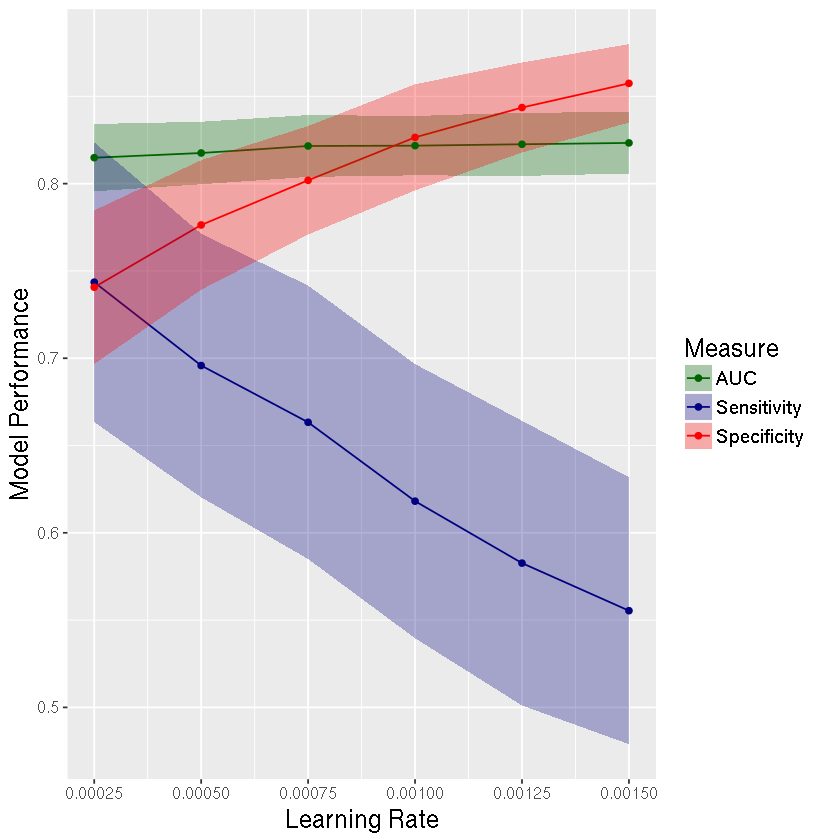

In [84]:
# Continuous plot

ggplot(to_plot_large, aes(lr, measure_mean,  group = Measure,  color = Measure)) +
  geom_line() + 
  geom_ribbon(aes(ymin=measure_mean-dt, ymax=measure_mean+dt, fill=Measure),
              linetype="blank",
              alpha=0.3) +
  geom_point() +
  scale_fill_manual(values=c("darkgreen", "navyblue", "red")) + # change shadow color here 
  scale_colour_manual(values=c("darkgreen", "navyblue", "red")) + # change line color here
  labs(x = "Learning Rate", y = "Model Performance") +
  theme(axis.title = element_text(size=15),
        axis.text = element_text(size=11),
        legend.title=element_text(size=15),
        legend.text=element_text(size=13)) +
  scale_x_continuous(labels = function(x) gsub(',', '.', sprintf("%.5f", x)), 
      limits = c(lr[1], lr[length(lr)]), breaks = lr) +
  scale_y_continuous(labels = function(x) gsub(',', '.', x))

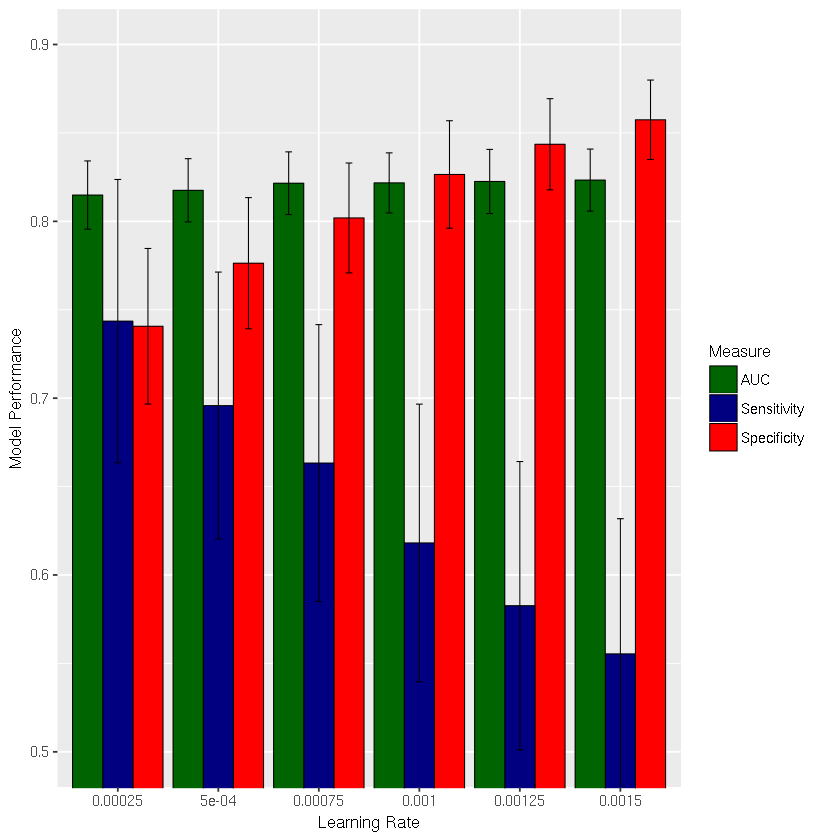

In [127]:
# Barplot

ggplot(to_plot_large, aes(factor(lr), measure_mean,  fill = Measure,  color = Measure)) +
  geom_bar(stat="identity", position=position_dodge(), 
           colour="black", size=.3) +
  geom_errorbar(aes(ymin=measure_mean-dt, ymax=measure_mean+dt),
                size=.3, width=.2, colour="black",
                position=position_dodge(.9)) +
  scale_fill_manual(values=c("darkgreen", "navyblue", "red")) + # change shadow color here 
  scale_colour_manual(values=c("darkgreen", "navyblue", "red")) + # change line color here
  labs(x = "Learning Rate", y = "Model Performance") +
  coord_cartesian(ylim = c(0.5, 0.9)) 

In [80]:
# Using all phosphorylation data

library("ggplot2")
library("tidyr")

# You only have to name your vectors as :
# 'lr' for learning rate 
# 'sensitivity' for sensitivity mean
# 'dt_sens' for sensitivity standard deviation
# 'specificity' for specificity mean
# 'dt_sp' for specificity standard deviation


lr <- seq(from = 0.00025, to = 0.0015, by = 0.00025)

model.config <- c('Custom STY 1 all lr=0.00025', 'Custom STY 1 all lr=0.0005', 'Custom STY 1 all lr=0.00075', 
                  'Custom STY 1 all', 'Custom STY 1 all lr=0.00125', 'Custom STY 1 all lr=0.0015')

dt.mean <- bootstrap.mean[model.config, ]

dt.std <- bootstrap.std[model.config, ]

AUC <- dt.mean[, 'ROC']
dt_auc <- dt.std[, 'ROC']

Sensitivity <- dt.mean[, 'Sens']
dt_sens <- dt.std[, 'Sens']

Specificity <- dt.mean[, 'Spec']
dt_sp <- dt.std[, 'Spec']

to_plot_wide <- data.frame(lr, AUC, Sensitivity, Specificity)
to_plot_large <- gather(to_plot_wide, Measure, measure_mean,
                        AUC:Specificity)
to_plot_large$dt <- c(dt_auc, dt_sens, dt_sp)

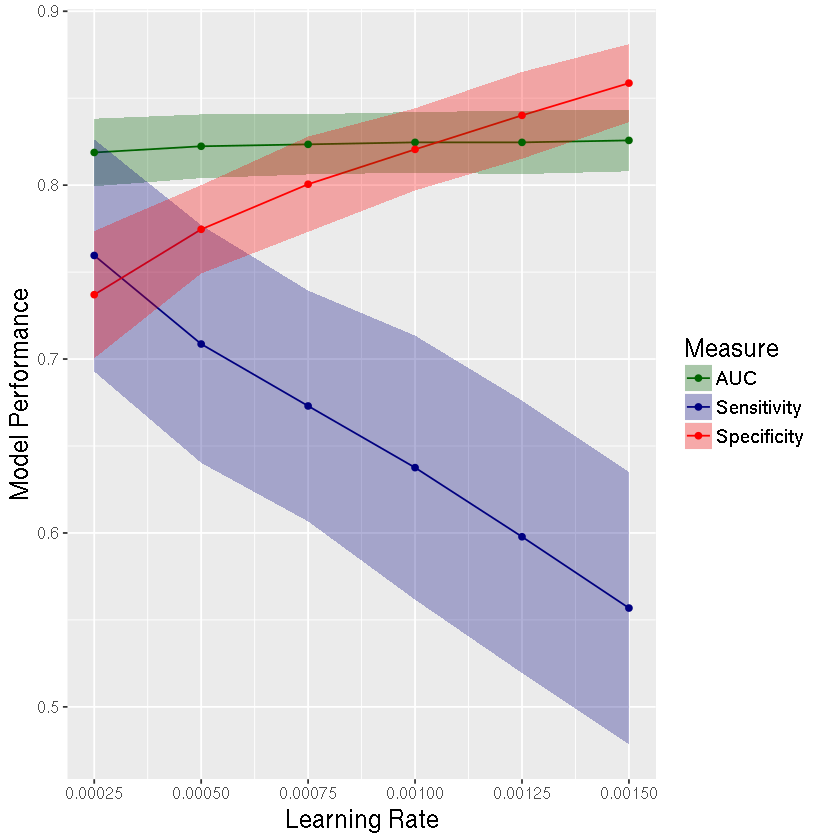

In [92]:
# Continuous plot

ggplot(to_plot_large, aes(lr, measure_mean,  group = Measure,  color = Measure)) +
  geom_line() + 
  geom_ribbon(aes(ymin=measure_mean-dt, ymax=measure_mean+dt, fill=Measure),
              linetype="blank",
              alpha=0.3) +
  geom_point() +
  scale_fill_manual(values=c("darkgreen", "navyblue", "red")) + # change shadow color here 
  scale_colour_manual(values=c("darkgreen", "navyblue", "red")) + # change line color here
  labs(x = "Learning Rate", y = "Model Performance") +
  theme(axis.title = element_text(size=15),
        axis.text = element_text(size=11),
        legend.title=element_text(size=15),
        legend.text=element_text(size=13)) +
  scale_x_continuous(labels = function(x) gsub(',', '.', sprintf("%.5f", x)), 
      limits = c(lr[1], lr[length(lr)]), breaks = lr) +
  scale_y_continuous(labels = function(x) gsub(',', '.', x))

In [141]:
# All-phos-data: Compare the results obtained using different values of transfer-leayer

tl.names <- c('Custom STY 1', 'Custom STY 1 all', 'Custom STY 1 tl=0', 'Custom STY 1 all tl=0', 
              'Custom STY 1 tl=3', 'Custom STY 1 all tl=3', 'Custom STY 1 tl=5', 'Custom STY 1 all tl=5')

# Mean values
bootstrap.mean[tl.names, ]

# Std values
bootstrap.std[tl.names, ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0.5,0.8217410,0.8114550,0.6181205,0.8265041,0.2153332,0.6181205,0.2828989,0.3170213
Custom STY 1 all,0.5,0.8246012,0.8074669,0.6375656,0.8205609,0.2139331,0.6375656,0.2875487,0.3187854
Custom STY 1 tl=0,0.5,0.8245398,0.8425331,0.5291196,0.8666904,0.2327569,0.5291196,0.2754782,0.3212464
Custom STY 1 all tl=0,0.5,0.8250863,0.8423129,0.5249736,0.8667667,0.2315154,0.5249736,0.2729259,0.3192354
Custom STY 1 tl=3,0.5,0.8241034,0.8140322,0.6157164,0.8294244,0.2168887,0.6157164,0.2843080,0.3187090
Custom STY 1 all tl=3,0.5,0.8249449,0.8140320,0.6150379,0.8294010,0.2168772,0.6150379,0.2840662,0.3185954
Custom STY 1 tl=5,0.5,0.7988128,0.8012111,0.5978105,0.8169712,0.2003205,0.5978105,0.2600943,0.2980977
Custom STY 1 all tl=5,0.5,0.8045615,0.8031159,0.6016179,0.8187353,0.2036052,0.6016179,0.2646956,0.3020633


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0,0.01698192,0.02474074,0.07850784,0.03039642,0.02931676,0.07850784,0.03415991,0.03266144
Custom STY 1 all,0,0.01743957,0.01928497,0.07592377,0.02360048,0.02810978,0.07592377,0.03759002,0.03459311
Custom STY 1 tl=0,0,0.01679904,0.01426467,0.07325067,0.01799328,0.03096235,0.07325067,0.03892950,0.03513597
Custom STY 1 all tl=0,0,0.01772713,0.01356486,0.07176126,0.01733374,0.03150495,0.07176126,0.03872839,0.03512651
Custom STY 1 tl=3,0,0.01640292,0.02095216,0.07443567,0.02607940,0.02726320,0.07443567,0.03306265,0.03073168
Custom STY 1 all tl=3,0,0.01733322,0.02057429,0.07634665,0.02566744,0.02999000,0.07634665,0.03602866,0.03418386
Custom STY 1 tl=5,0,0.01852090,0.02218515,0.07970201,0.02796135,0.02740479,0.07970201,0.03477149,0.03218194
Custom STY 1 all tl=5,0,0.02037681,0.02553507,0.07873155,0.03094027,0.02843163,0.07873155,0.03574793,0.03256460


In [131]:
# To produce the Table results in the paper

bm <- bootstrap.mean[c('Custom STY 1 tl=0', 'Custom STY 1', 'Custom STY 1 tl=3', 'Custom STY 1 tl=5'), 
                     c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')]
bd <- bootstrap.std[c('Custom STY 1 tl=0', 'Custom STY 1', 'Custom STY 1 tl=3', 'Custom STY 1 tl=5'), 
                     c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')]
m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom STY 1 tl=0,0.8245 0.0168,0.8425 0.0143,0.5291 0.0733,0.8667 0.018,0.3212 0.0351,0.2755 0.0389
Custom STY 1,0.8217 0.017,0.8115 0.0247,0.6181 0.0785,0.8265 0.0304,0.317 0.0327,0.2829 0.0342
Custom STY 1 tl=3,0.8241 0.0164,0.814 0.021,0.6157 0.0744,0.8294 0.0261,0.3187 0.0307,0.2843 0.0331
Custom STY 1 tl=5,0.7988 0.0185,0.8012 0.0222,0.5978 0.0797,0.817 0.028,0.2981 0.0322,0.2601 0.0348


In [142]:
# Using all-phos-data: To produce the Table results in the paper

lr.names <- c('Custom STY 1 all tl=0', 'Custom STY 1 all', 'Custom STY 1 all tl=3', 'Custom STY 1 all tl=5')

metric.names <- c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')

bm <- bootstrap.mean[lr.names, metric.names]
bd <- bootstrap.std[lr.names, metric.names]

m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom STY 1 all tl=0,0.8251 0.0177,0.8423 0.0136,0.525 0.0718,0.8668 0.0173,0.3192 0.0351,0.2729 0.0387
Custom STY 1 all,0.8246 0.0174,0.8075 0.0193,0.6376 0.0759,0.8206 0.0236,0.3188 0.0346,0.2875 0.0376
Custom STY 1 all tl=3,0.8249 0.0173,0.814 0.0206,0.615 0.0763,0.8294 0.0257,0.3186 0.0342,0.2841 0.036
Custom STY 1 all tl=5,0.8046 0.0204,0.8031 0.0255,0.6016 0.0787,0.8187 0.0309,0.3021 0.0326,0.2647 0.0357


In [133]:
# Compare the results obtained using different values of learning-rate and transfer-leayer

# Mean values
bootstrap.mean[c('Custom STY 1', 'Custom STY 1 tl=0 lr=0.0005', 'Custom STY 1 tl=3 lr=0.0005', 
                 'Custom STY 1 tl=0 lr=0.00025', 'Custom STY 1 tl=3 lr=0.00025'), ]

# Std values
bootstrap.std[c('Custom STY 1', 'Custom STY 1 tl=0 lr=0.0005', 'Custom STY 1 tl=3 lr=0.0005', 
                 'Custom STY 1 tl=0 lr=0.00025', 'Custom STY 1 tl=3 lr=0.00025'), ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0.5,0.8217410,0.8114550,0.6181205,0.8265041,0.2153332,0.6181205,0.2828989,0.3170213
Custom STY 1 tl=0 lr=0.0005,0.5,0.8251856,0.8061367,0.6260293,0.8200547,0.2104764,0.6260293,0.2801589,0.3134670
Custom STY 1 tl=3 lr=0.0005,0.5,0.8198352,0.7697866,0.7062631,0.7747343,0.1940078,0.7062631,0.2818853,0.3029947
Custom STY 1 tl=0 lr=0.00025,0.5,0.8228158,0.7684508,0.6975388,0.7740034,0.1914203,0.6975388,0.2761704,0.2990925
Custom STY 1 tl=3 lr=0.00025,0.5,0.8147823,0.7292627,0.7633252,0.7266700,0.1764331,0.7633252,0.2726953,0.2856552


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1,0,0.01698192,0.02474074,0.07850784,0.03039642,0.02931676,0.07850784,0.03415991,0.03266144
Custom STY 1 tl=0 lr=0.0005,0,0.01642767,0.01912112,0.06733338,0.02318086,0.02713899,0.06733338,0.03390408,0.03209078
Custom STY 1 tl=3 lr=0.0005,0,0.01764179,0.02562298,0.07162577,0.03101453,0.02421960,0.07162577,0.03105130,0.02994150
Custom STY 1 tl=0 lr=0.00025,0,0.01679816,0.02389941,0.06711807,0.02869490,0.02397143,0.06711807,0.03038320,0.02963839
Custom STY 1 tl=3 lr=0.00025,0,0.01766212,0.02954489,0.06707871,0.03502221,0.02053478,0.06707871,0.02741737,0.02720495


In [143]:
# To produce the Table results in the paper

bm <- bootstrap.mean[c('Custom STY 1 tl=0 lr=0.00025', 'Custom STY 1 tl=0 lr=0.0005'), 
                     c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')]
bd <- bootstrap.std[c('Custom STY 1 tl=0 lr=0.00025', 'Custom STY 1 tl=0 lr=0.0005'), 
                     c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')]
m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom STY 1 tl=0 lr=0.00025,0.8228 0.0168,0.7685 0.0239,0.6975 0.0671,0.774 0.0287,0.2991 0.0296,0.2762 0.0304
Custom STY 1 tl=0 lr=0.0005,0.8252 0.0164,0.8061 0.0191,0.626 0.0673,0.8201 0.0232,0.3135 0.0321,0.2802 0.0339


In [135]:
# Using all-phos-data: To produce the Table results in the paper

bm <- bootstrap.mean[c('Custom STY 1 all tl=0 lr=0.00025', 'Custom STY 1 all tl=3 lr=0.00025', 
                       'Custom STY 1 all tl=0 lr=0.0005', 'Custom STY 1 all tl=3 lr=0.0005'), 
                     c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')]
bd <- bootstrap.std[c('Custom STY 1 tl=0 lr=0.00025', 'Custom STY 1 tl=0 lr=0.0005'), 
                     c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')]
m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom STY 1 all tl=0 lr=0.00025,0.826 0.0168,0.7734 0.0671,0.6971 0.0296,0.7792 0.0168,0.3038 0.0671,0.281 0.0296
Custom STY 1 all tl=3 lr=0.00025,0.8164 0.0164,0.7374 0.0673,0.761 0.0321,0.7357 0.0164,0.2911 0.0673,0.2784 0.0321
Custom STY 1 all tl=0 lr=0.0005,0.8267 0.0239,0.8062 0.0287,0.6312 0.0304,0.8197 0.0239,0.3152 0.0287,0.2828 0.0304
Custom STY 1 all tl=3 lr=0.0005,0.8211 0.0191,0.7739 0.0232,0.7054 0.0339,0.7792 0.0191,0.3064 0.0232,0.2854 0.0339
